# **PROJETO INTEGRADOR - GRUPO 03**

***Lucas, Patrícia, Tiago & Victor Wood***


---



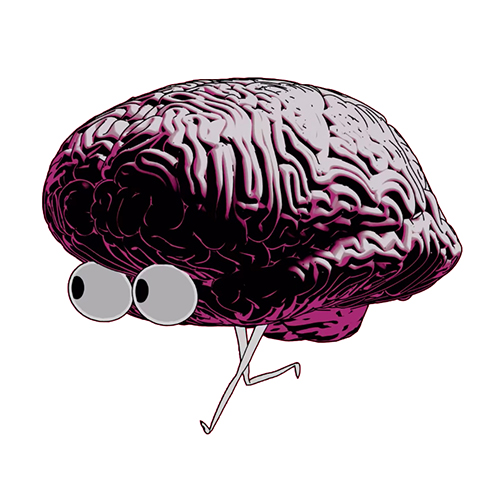

## Documentação datasets Yelp:
https://www.yelp.com/dataset/documentation/faq


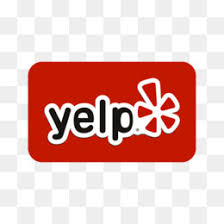


--------------------------------------------------------------------------------

## O Problema de negócio: 
Predizer qual será a nota do estabelecimento levando em consideração os atributos de acessibilidade | facility(espaço para cadeirantes, aceita cachorros, espaço para crianças etc.)

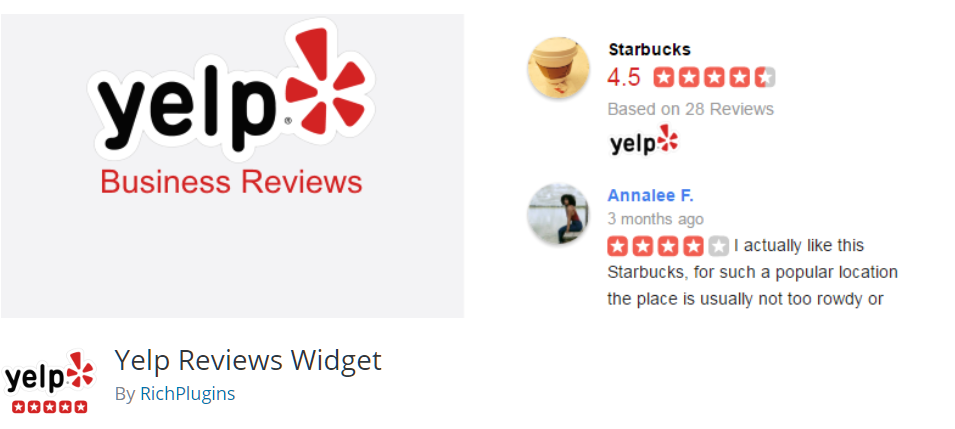

## Estratégias para solução do problema:
 
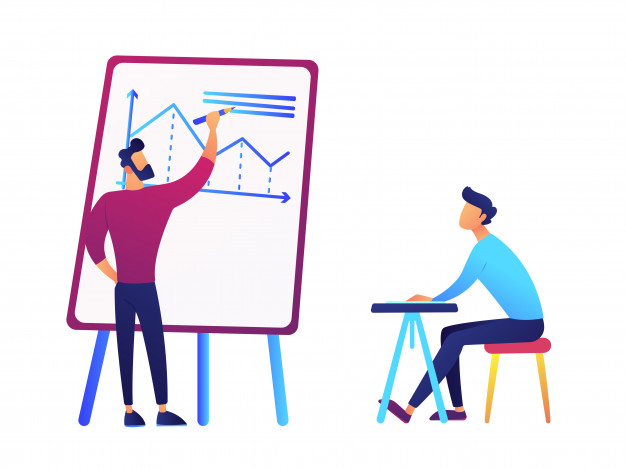






* Avaliar por questões de Acessibilidade: Aceita cartões| Aceita pets| Tem estacionamento etc... 
* Coletar dados nos portais de avaliações dos estabelecimentos para conseguirmos essas informações.
* Analisar os dados coletados.
* Criar um modelo de regressão para prever qual será a nota do usuário, identificando as variáveis que impactam no bom funcionamento de um estabelecimento por região.
* Dados para serem treinados: Região | Acessibilidade| Tipos de estabelecimentos|Avaliações(target).

 
 
 
 
 
 ----------------------------------------------------------------------------------------



## Ciclos
  * Ciclo 00: Coletar os dados nos portais de avaliações
  * Ciclo 01: Analise exploratória inicial dos dados coletados, entender a base
  * Ciclo 02: Limpeza dos dados 
  * Ciclo 03: Analise exploratoria mais aprofundada dos dados
  * Ciclo 04: Escolha das Feature
  * Ciclo 05: Levantar Hipoteses:
      * ---- Quais itens de acessibilidade(aceitar cartão, aceitar pets etc...) tem um maior impacto para um estabelecimento.
      * ----  Qual o impacto desses itens de acessibilidade por região

  * Ciclo 06: Fazer análise e validação dessas hipóteses 
  * Ciclo 07: Preparar os dados para treino e teste
  * Ciclo 08: Aplicar  os algoritmos de Machine learning
  * Ciclo 09: Aplicar métricas de performance do modelo
  * Ciclo 10: Colocar o modelo em produção


  ---------------------------------------------------------------------------------

# 1 Importação e tratamento dos dados

## 1.0 Importando bibliotecas

In [179]:
pickle --version

NameError: name 'pickle' is not defined

In [1]:
# Importar bases do Google Drive
# from google.colab import drive
# import os


# Básicas
import numpy as np
import pandas as pd
import numpy as np
import json

# Geolocalização
from geopy.distance import geodesic

# Gráficos
import seaborn as sns
import matplotlib.pyplot as plt
import folium
from folium.plugins import HeatMap

# Biblioteca para preparacao dos dados para modelagem
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing 

#Blioteca para balanceamento 
from imblearn.under_sampling import NearMiss
import imblearn
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn import under_sampling
from imblearn import over_sampling
from collections import Counter

#Bibliotecas de avalicao e validacao dos modelos
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import r2_score
from sklearn import metrics
from sklearn.metrics import classification_report
from imblearn.metrics import classification_report_imbalanced
from sklearn.model_selection import StratifiedKFold # Essa biblioteca mistura os dados e garante que todos tenham informação
from sklearn.metrics import f1_score
from sklearn.feature_selection import RFE

# Biblioteca para explicação do modelo
import shap

# Bibliotecas para Modelagem
from sklearn.tree import DecisionTreeClassifier,export_graphviz
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, StackingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
 

# Aplicando ajuste dos hiperparametros
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

# !pip install pycaret
# import pycaret
# from pycaret.classification import *
from sklearn.preprocessing import RobustScaler

## 1.1 Salvando fórmulas de EDA

In [2]:
def EDA_values(df):
    print("")
    counter=0

    # identifica a qtd de caracteres da maior coluna para depois poder calcular quantos espacos sao necessarios para que as colunas com nomes 
    # menores fiquem alinhadas
    max_col_name_char = 0
    for col_name in df.columns:
        if len(col_name) > max_col_name_char:
            max_col_name_char = len(col_name)+1

    # calcula a qtd de colunas para depois poder calcular quantos espacos sao necessarios para que os indices das colunas fiquem alinhados 
    if len(df.columns) < 10:
        digits = 0
    elif len(df.columns) < 100:
        digits = 1
    else:
        digits = 2

    for i in df.columns:
        if len(df[i].unique()) < 23:
            print(' '*(digits-counter//10), counter, '|', i, ' '*(max_col_name_char - len(i))+'| ', df[i].unique())
        else:
            try:
                print(' '*(digits-counter//10), counter, '|', i, ' '*(max_col_name_char - len(i))+'|  '+'Min:', data[i].unique().min(), '| Max:', data[i].unique().max(), '| Avg:',round(df[i].dropna().unique().mean(),2), '| Median:',round(np.median(df[i].dropna().unique()),2))
            except:
                print(' '*(digits-counter//10), counter, '|', i, ' '*(max_col_name_char - len(i))+'|  '+'Min:', df[i].unique().min(), '| Max:', df[i].unique().max())

        counter += 1
    return None

In [3]:
def normal(df, col, threshold=0.05):
    try:
        zscore, p_value = stats.normaltest(df[col])
        if p_value < threshold:
            result = 'not_normal'
        else:
            result = 'normal'
    except:
        zscore = p_value = np.nan
        result = 'not_applicable'
    return result

def outliers_count_IQR(df, col):
    try:
        if len(df[col].unique())>2: # if para eliminar features binárias
            q1 = df[col].quantile(0.25)
            q3 = df[col].quantile(0.75)
            iqr_range = q3 - q1
            lower = q1 - 1.5*iqr_range
            upper = q3 + 1.5*iqr_range
            out_low = df[df[col] < lower].count()[0]
            out_up = df[df[col] > upper].count()[0]
            outliers = out_low + out_up
            outliers_perc = round(outliers / df.shape[0],2)
        else:
            outliers = np.nan
            outliers_perc = np.nan
    except:
        outliers = np.nan
        outliers_perc = np.nan
    return outliers, outliers_perc

def EDA_morestats(df):
    eda_df = {}
    eda_df['Amount_NaN'] = df.isnull().sum()
    eda_df['%_NaN'] = df.isnull().mean().round(2)
    eda_df['DType'] = df.dtypes
    eda_df['Amount_Data'] = df.count()
    colunas = df.columns.tolist()
    eda_df['Mean'] = df.mean().round(3)
    eda_df['Min'] = df.min()
    eda_df['Max'] = df.max()
    eda_df['STD'] = df.std().round(3)
    eda_df['Normality'] = pd.Series(map(lambda x: normal(df, x), colunas), index=colunas)
    eda_df['Amount_Outliers'] = pd.Series(map(lambda x: outliers_count_IQR(df, x)[0], colunas), index=colunas)
    eda_df['%_Outliers'] = pd.Series(map(lambda x: outliers_count_IQR(df, x)[1], colunas), index=colunas)
    df = pd.DataFrame(eda_df)
    return df.loc[colunas,:]

## 1.2 Importação e tratamento de bases

In [4]:
#Montando o Google Drive no Colab
# drive.mount('/content/drive')

In [5]:
#Listando conteúdo do diretório para importação das basees
# os.chdir("/content/drive/My Drive/Yelp_datasets")
# os.listdir()

### 1.2.1 Importando e tratando base 1/2 - "CATEGORIES"

In [6]:
# Importação da base "CATEGORIES"
df_categories = pd.read_json('categories.json', lines= False )
df_categories.head()

,alias,title,parents,country_whitelist,country_blacklist
0,3dprinting,3D Printing,[localservices],NaN,NaN
1,abruzzese,Abruzzese,[italian],[IT],NaN
2,absinthebars,Absinthe Bars,[bars],[CZ],NaN
3,acaibowls,Acai Bowls,[food],NaN,"[AR, TR, IT, PL, MX, CL]"
4,accessories,Accessories,[fashion],NaN,NaN


In [7]:
df_categories.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   alias              1565 non-null   object
 1   title              1565 non-null   object
 2   parents            1565 non-null   object
 3   country_whitelist  531 non-null    object
 4   country_blacklist  352 non-null    object
dtypes: object(5)
memory usage: 61.3+ KB


In [8]:
# Precisamos somente das duas primeiras colunas
df_categories = df_categories[['title', 'parents']]
df_categories.head()

,title,parents
0,3D Printing,[localservices]
1,Abruzzese,[italian]
2,Absinthe Bars,[bars]
3,Acai Bowls,[food]
4,Accessories,[fashion]


In [9]:
# Observando se existem categorias repetidas
print(df_categories.shape)
print(df_categories['title'].unique().shape)

(1565, 2)
(1565,)


In [10]:
# Extraindo somente as informações texto da coluna parents (eliminando o colchete)
parents = df_categories['parents'].apply(pd.Series).drop(columns=[1,2])
parents.columns = ['Parents']
parents.head()

,Parents
0,localservices
1,italian
2,bars
3,food
4,fashion


In [11]:
# Unindo a tabela parents à tabela df_categories
df_categories = pd.concat([df_categories, parents], axis = 1).drop(columns=['parents'])
df_categories['title'] = df_categories['title'].replace({' ':''}, regex=True).str.lower()
df_categories['Parents'] = df_categories['Parents'].replace({' ':''}, regex=True).str.lower()
display(df_categories)

,title,Parents
0,3dprinting,localservices
1,abruzzese,italian
2,absinthebars,bars
3,acaibowls,food
4,accessories,fashion
...,...,...
1560,yugoslav,restaurants
1561,zapiekanka,food
1562,ziplining,active
1563,zoos,active


In [12]:
# Renomenando as colunas
df_categories['categoria_macro'] = df_categories['Parents']
df_categories['categoria_micro'] = df_categories['title']
df_categories = df_categories.drop(columns=['Parents','title'])
df_categories.head()

,categoria_macro,categoria_micro
0,localservices,3dprinting
1,italian,abruzzese
2,bars,absinthebars
3,food,acaibowls
4,fashion,accessories


In [13]:
# Analisando dados nulos na coluna 'categoria_macro'
df_categories[df_categories['categoria_macro'].isnull()]

,categoria_macro,categoria_micro
7,NaN,activelife
68,NaN,arts&entertainment
87,NaN,automotive
136,NaN,beauty&spas
154,NaN,bicycles
443,NaN,education
483,NaN,eventplanning&services
509,NaN,financialservices
535,NaN,food
642,NaN,health&medical


In [14]:
# Analisando dados nulos na coluna 'categoria_micro'
df_categories[df_categories['categoria_micro'].isnull()]

,categoria_macro,categoria_micro


In [15]:
# Substituindo os NaN
df_categories['categoria_macro'].fillna(df_categories['categoria_micro'], inplace=True)

In [16]:
df_categories[df_categories['categoria_macro'].isnull()]

,categoria_macro,categoria_micro


In [17]:
# Observando os dados únicos
df_categories['categoria_macro'].unique().tolist()

['localservices',
 'italian',
 'bars',
 'food',
 'fashion',
 'professional',
 'beautysvc',
 'activelife',
 'health',
 'physicians',
 'shopping',
 'education',
 'nightlife',
 'fitness',
 'tours',
 'medicalspa',
 'restaurants',
 'religiousorgs',
 'hotels',
 'auto',
 'transport',
 'hotelstravel',
 'airports',
 'active',
 'portuguese',
 'french',
 'petservices',
 'pets',
 'realestateagents',
 'realestate',
 'homeandgarden',
 'arabian',
 'arts',
 'spanish',
 'homeservices',
 'museums',
 'arts&entertainment',
 'specialtyschools',
 'artsandcrafts',
 'psychic_astrology',
 'farms',
 'partyequipmentrentals',
 'publicservicesgovt',
 'automotive',
 'insurance',
 'plumbing',
 'german',
 'eventservices',
 'lawyers',
 'financialservices',
 'beauty&spas',
 'bicycles',
 'sportgoods',
 'petstore',
 'japanese',
 'hair',
 'media',
 'photographers',
 'brazilian',
 'martialarts',
 'breweries',
 'medcenters',
 'gourmet',
 'cannabis_clinics',
 'chinese',
 'autoglass',
 'turkish',
 'tastingclasses',
 'gyms',
 

#### 1.2.1.1 Criando filtro relativo a categorias

In [18]:
# Criando uma lista que servirá de filtro na próxima base
lista_categorias_macro = ['italian',
'food',
'restaurants',
'portuguese',
'french',
'arabian',
'spanish',
'german',
'japanese',
'bars',
'chinese',
'brazilian',
'breweries',
'gourmet',
'turkish',
'latin',
'caribbean',
'mexican',
'mideastern',
'mediterranean',
'belgian',
'malaysian',
'jpsweets',
'cafes',
'wineries']

Este filtro servirá para filtrar a base "BUSINESS" de acordo com o escopo do nosso projeto

### 1.2.2 Importando e tratando base 2/2 - "BUSINESS"

#### 1.2.2.0 Importação do df "BUSINESS"

In [19]:
# Importação da base "BUSINESS"
df_business0 = pd.read_json('yelp_academic_dataset_business.json', lines= True)
df_business0.head()

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
0,f9NumwFMBDn751xgFiRbNA,The Range At Lake Norman,10913 Bailey Rd,Cornelius,NC,28031,35.462724,-80.852612,3.5,36,1,"{'BusinessAcceptsCreditCards': 'True', 'BikePa...","Active Life, Gun/Rifle Ranges, Guns & Ammo, Sh...","{'Monday': '10:0-18:0', 'Tuesday': '11:0-20:0'..."
1,Yzvjg0SayhoZgCljUJRF9Q,"Carlos Santo, NMD","8880 E Via Linda, Ste 107",Scottsdale,AZ,85258,33.569404,-111.890264,5.0,4,1,"{'GoodForKids': 'True', 'ByAppointmentOnly': '...","Health & Medical, Fitness & Instruction, Yoga,...",None
2,XNoUzKckATkOD1hP6vghZg,Felinus,3554 Rue Notre-Dame O,Montreal,QC,H4C 1P4,45.479984,-73.580070,5.0,5,1,None,"Pets, Pet Services, Pet Groomers",None
3,6OAZjbxqM5ol29BuHsil3w,Nevada House of Hose,1015 Sharp Cir,North Las Vegas,NV,89030,36.219728,-115.127725,2.5,3,0,"{'BusinessAcceptsCreditCards': 'True', 'ByAppo...","Hardware Stores, Home Services, Building Suppl...","{'Monday': '7:0-16:0', 'Tuesday': '7:0-16:0', ..."
4,51M2Kk903DFYI6gnB5I6SQ,USE MY GUY SERVICES LLC,4827 E Downing Cir,Mesa,AZ,85205,33.428065,-111.726648,4.5,26,1,"{'BusinessAcceptsCreditCards': 'True', 'ByAppo...","Home Services, Plumbing, Electricians, Handyma...","{'Monday': '0:0-0:0', 'Tuesday': '9:0-16:0', '..."


*  "business_id": // string, 22 character unique string business id
* "name": // string, the business's name
* "address": // string, the full address of the business
* "city": // string, the city
* "state": // string, 2 character state code, if applicable
* "postal code": // string, the postal code
* "latitude": // float, latitude
* "longitude": // float, longitude
* "stars": // float, star rating, rounded to half-stars
*  "review_count": // integer, number of reviews
* "is_open": // integer, 0 or 1 for closed or open, respectively
*  "attributes": // object, business attributes to values. note: some attribute values might be objects
* "categories": // an array of strings of business categories
* "hours": // an object of key day to value hours, hours are using a 24hr cloc

#### 1.2.2.1 Filtrando só estabelecimentos pertencentes aos maiores municípios

In [20]:
# Criando uma nova coluna pois há cidades repetidas em diferentes Estados
df_business0['city_and_state'] = df_business0['city'] + ' - ' + df_business0['state']
df_business0.head()

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours,city_and_state
0,f9NumwFMBDn751xgFiRbNA,The Range At Lake Norman,10913 Bailey Rd,Cornelius,NC,28031,35.462724,-80.852612,3.5,36,1,"{'BusinessAcceptsCreditCards': 'True', 'BikePa...","Active Life, Gun/Rifle Ranges, Guns & Ammo, Sh...","{'Monday': '10:0-18:0', 'Tuesday': '11:0-20:0'...",Cornelius - NC
1,Yzvjg0SayhoZgCljUJRF9Q,"Carlos Santo, NMD","8880 E Via Linda, Ste 107",Scottsdale,AZ,85258,33.569404,-111.890264,5.0,4,1,"{'GoodForKids': 'True', 'ByAppointmentOnly': '...","Health & Medical, Fitness & Instruction, Yoga,...",None,Scottsdale - AZ
2,XNoUzKckATkOD1hP6vghZg,Felinus,3554 Rue Notre-Dame O,Montreal,QC,H4C 1P4,45.479984,-73.580070,5.0,5,1,None,"Pets, Pet Services, Pet Groomers",None,Montreal - QC
3,6OAZjbxqM5ol29BuHsil3w,Nevada House of Hose,1015 Sharp Cir,North Las Vegas,NV,89030,36.219728,-115.127725,2.5,3,0,"{'BusinessAcceptsCreditCards': 'True', 'ByAppo...","Hardware Stores, Home Services, Building Suppl...","{'Monday': '7:0-16:0', 'Tuesday': '7:0-16:0', ...",North Las Vegas - NV
4,51M2Kk903DFYI6gnB5I6SQ,USE MY GUY SERVICES LLC,4827 E Downing Cir,Mesa,AZ,85205,33.428065,-111.726648,4.5,26,1,"{'BusinessAcceptsCreditCards': 'True', 'ByAppo...","Home Services, Plumbing, Electricians, Handyma...","{'Monday': '0:0-0:0', 'Tuesday': '9:0-16:0', '...",Mesa - AZ


In [21]:
# Criando um filtro para a base conter apenas estabelecimentos dos 5 maiores municípios no múmero de estabelecimentos
lista_cidades = pd.DataFrame(df_business0['city_and_state'].value_counts()).reset_index()['index'].tolist()
lista_cidades_filtro = lista_cidades[0:5]
print(lista_cidades_filtro)

['Las Vegas - NV', 'Toronto - ON', 'Phoenix - AZ', 'Charlotte - NC', 'Scottsdale - AZ']


In [22]:
# Filtrando a base conforme o filtro acima
df_business1 = df_business0[df_business0['city_and_state'].isin(lista_cidades_filtro)].reset_index().drop(columns = ['index'])
df_business1.head()

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours,city_and_state
0,Yzvjg0SayhoZgCljUJRF9Q,"Carlos Santo, NMD","8880 E Via Linda, Ste 107",Scottsdale,AZ,85258,33.569404,-111.890264,5.0,4,1,"{'GoodForKids': 'True', 'ByAppointmentOnly': '...","Health & Medical, Fitness & Instruction, Yoga,...",None,Scottsdale - AZ
1,oiAlXZPIFm2nBCt0DHLu_Q,Green World Cleaners,"6870 S Rainbow Blvd, Ste 117",Las Vegas,NV,89118,36.063977,-115.241463,3.5,81,1,"{'BusinessParking': '{'garage': False, 'street...","Dry Cleaning & Laundry, Local Services, Laundr...","{'Monday': '7:0-19:0', 'Tuesday': '7:0-19:0', ...",Las Vegas - NV
2,EosRKXIGeSWFYWwpkbhNnA,Xtreme Couture,700 Kipling Avenue Etobicoke,Toronto,ON,M8Z 5G3,43.624539,-79.529108,3.0,16,1,"{'GoodForKids': 'True', 'ByAppointmentOnly': '...","Martial Arts, Gyms, Fitness & Instruction, Act...","{'Monday': '5:30-23:0', 'Tuesday': '5:30-23:0'...",Toronto - ON
3,uZuh51lXu7tsrC8RAwkg1A,Manolo Blahnik,3131 Las Vegas Blvd,Las Vegas,NV,89109,36.125732,-115.167608,4.5,32,0,"{'BusinessParking': '{'garage': True, 'street'...","Shopping, Shoe Stores, Fashion",None,Las Vegas - NV
4,CsLQLiRoafpJPJSkNX2h5Q,Middle East Deli,4508 E Independence Blvd,Charlotte,NC,28205,35.194894,-80.767442,3.0,5,0,"{'RestaurantsGoodForGroups': 'True', 'OutdoorS...","Food, Restaurants, Grocery, Middle Eastern",None,Charlotte - NC


In [23]:
df_business1.shape

(91915, 15)

#### 1.2.2.2 Filtrando só estabelecimentos em funcionamento

In [24]:
# Assim não perdemos informação de horário de funcionamento
df_business2 = df_business1.loc[df_business1['is_open'] == 1].drop(columns = ['is_open'])
df_business2.shape

(72134, 14)

In [25]:
df_business2.columns

Index(['business_id', 'name', 'address', 'city', 'state', 'postal_code',
       'latitude', 'longitude', 'stars', 'review_count', 'attributes',
       'categories', 'hours', 'city_and_state'],
      dtype='object')

#### 1.2.2.3 Organizando categorias

In [26]:
# Criando novo df cópia
df_business3 = df_business2
df_business3.head()

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,attributes,categories,hours,city_and_state
0,Yzvjg0SayhoZgCljUJRF9Q,"Carlos Santo, NMD","8880 E Via Linda, Ste 107",Scottsdale,AZ,85258,33.569404,-111.890264,5.0,4,"{'GoodForKids': 'True', 'ByAppointmentOnly': '...","Health & Medical, Fitness & Instruction, Yoga,...",None,Scottsdale - AZ
1,oiAlXZPIFm2nBCt0DHLu_Q,Green World Cleaners,"6870 S Rainbow Blvd, Ste 117",Las Vegas,NV,89118,36.063977,-115.241463,3.5,81,"{'BusinessParking': '{'garage': False, 'street...","Dry Cleaning & Laundry, Local Services, Laundr...","{'Monday': '7:0-19:0', 'Tuesday': '7:0-19:0', ...",Las Vegas - NV
2,EosRKXIGeSWFYWwpkbhNnA,Xtreme Couture,700 Kipling Avenue Etobicoke,Toronto,ON,M8Z 5G3,43.624539,-79.529108,3.0,16,"{'GoodForKids': 'True', 'ByAppointmentOnly': '...","Martial Arts, Gyms, Fitness & Instruction, Act...","{'Monday': '5:30-23:0', 'Tuesday': '5:30-23:0'...",Toronto - ON
5,1wWneWD_E1pBIyVpdHMaQg,Air Jordan Store,306 Yonge Street,Toronto,ON,M5B 1R4,43.656542,-79.381308,4.0,9,"{'RestaurantsPriceRange2': '3', 'BikeParking':...","Shopping, Shoe Stores, Fashion","{'Monday': '10:0-21:0', 'Tuesday': '10:0-21:0'...",Toronto - ON
6,0pOlmHVeidsh63iAWdTAfg,Hendrick Motors of Charlotte - Mercedes-Benz,5201 E Independence Blvd,Charlotte,NC,28212,35.188018,-80.758758,2.5,32,{'BusinessAcceptsCreditCards': 'True'},"Auto Repair, Car Dealers, Automotive","{'Monday': '0:0-0:0', 'Tuesday': '7:30-19:0', ...",Charlotte - NC


In [27]:
# Removendo espaços e colocando todas as letras em minúsculo na coluna 'categories'
df_business3['categories'] = df_business3['categories'].replace({' ':''}, regex=True).str.lower()

In [28]:
# Inserindo coluna 'categories_micro' para desmembrar o dicionário  da coluna categories
df_business3 = pd.DataFrame(df_business3.assign(categoria_micro=df_business3['categories'].str.split(',')).explode('categoria_micro'))
df_business3.head()

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,attributes,categories,hours,city_and_state,categoria_micro
0,Yzvjg0SayhoZgCljUJRF9Q,"Carlos Santo, NMD","8880 E Via Linda, Ste 107",Scottsdale,AZ,85258,33.569404,-111.890264,5.0,4,"{'GoodForKids': 'True', 'ByAppointmentOnly': '...","health&medical,fitness&instruction,yoga,active...",None,Scottsdale - AZ,health&medical
0,Yzvjg0SayhoZgCljUJRF9Q,"Carlos Santo, NMD","8880 E Via Linda, Ste 107",Scottsdale,AZ,85258,33.569404,-111.890264,5.0,4,"{'GoodForKids': 'True', 'ByAppointmentOnly': '...","health&medical,fitness&instruction,yoga,active...",None,Scottsdale - AZ,fitness&instruction
0,Yzvjg0SayhoZgCljUJRF9Q,"Carlos Santo, NMD","8880 E Via Linda, Ste 107",Scottsdale,AZ,85258,33.569404,-111.890264,5.0,4,"{'GoodForKids': 'True', 'ByAppointmentOnly': '...","health&medical,fitness&instruction,yoga,active...",None,Scottsdale - AZ,yoga
0,Yzvjg0SayhoZgCljUJRF9Q,"Carlos Santo, NMD","8880 E Via Linda, Ste 107",Scottsdale,AZ,85258,33.569404,-111.890264,5.0,4,"{'GoodForKids': 'True', 'ByAppointmentOnly': '...","health&medical,fitness&instruction,yoga,active...",None,Scottsdale - AZ,activelife
0,Yzvjg0SayhoZgCljUJRF9Q,"Carlos Santo, NMD","8880 E Via Linda, Ste 107",Scottsdale,AZ,85258,33.569404,-111.890264,5.0,4,"{'GoodForKids': 'True', 'ByAppointmentOnly': '...","health&medical,fitness&instruction,yoga,active...",None,Scottsdale - AZ,pilates


In [29]:
# Concatenando as informações da variável df_categories['categoria macro'] ao df_business_teste
df_business3 = df_business3.merge(df_categories, on = 'categoria_micro', how = 'left')

In [30]:
# Eliminando a coluna 'categories' pois foi expandida
df_business3 = df_business3.drop(columns = ['categories'])

In [31]:
df_business3.head()

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,attributes,hours,city_and_state,categoria_micro,categoria_macro
0,Yzvjg0SayhoZgCljUJRF9Q,"Carlos Santo, NMD","8880 E Via Linda, Ste 107",Scottsdale,AZ,85258,33.569404,-111.890264,5.0,4,"{'GoodForKids': 'True', 'ByAppointmentOnly': '...",None,Scottsdale - AZ,health&medical,health&medical
1,Yzvjg0SayhoZgCljUJRF9Q,"Carlos Santo, NMD","8880 E Via Linda, Ste 107",Scottsdale,AZ,85258,33.569404,-111.890264,5.0,4,"{'GoodForKids': 'True', 'ByAppointmentOnly': '...",None,Scottsdale - AZ,fitness&instruction,active
2,Yzvjg0SayhoZgCljUJRF9Q,"Carlos Santo, NMD","8880 E Via Linda, Ste 107",Scottsdale,AZ,85258,33.569404,-111.890264,5.0,4,"{'GoodForKids': 'True', 'ByAppointmentOnly': '...",None,Scottsdale - AZ,yoga,fitness
3,Yzvjg0SayhoZgCljUJRF9Q,"Carlos Santo, NMD","8880 E Via Linda, Ste 107",Scottsdale,AZ,85258,33.569404,-111.890264,5.0,4,"{'GoodForKids': 'True', 'ByAppointmentOnly': '...",None,Scottsdale - AZ,activelife,activelife
4,Yzvjg0SayhoZgCljUJRF9Q,"Carlos Santo, NMD","8880 E Via Linda, Ste 107",Scottsdale,AZ,85258,33.569404,-111.890264,5.0,4,"{'GoodForKids': 'True', 'ByAppointmentOnly': '...",None,Scottsdale - AZ,pilates,fitness


#### 1.2.2.4 Filtrando só estabelecimentos pertencentes às categorias_macro definidas no 1.2.1.1

In [32]:
# Aplicando o filtro
df_business4 = df_business3[df_business3['categoria_macro'].isin(lista_categorias_macro)].reset_index().drop(columns = ['index'])
df_business4.head()

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,attributes,hours,city_and_state,categoria_micro,categoria_macro
0,vjTVxnsQEZ34XjYNS-XUpA,Wetzel's Pretzels,"4550 East Cactus Rd, #KSFC-4",Phoenix,AZ,85032,33.602822,-111.983533,4.0,10,"{'GoodForKids': 'True', 'RestaurantsTakeOut': ...","{'Monday': '10:0-21:0', 'Tuesday': '10:0-21:0'...",Phoenix - AZ,food,food
1,vjTVxnsQEZ34XjYNS-XUpA,Wetzel's Pretzels,"4550 East Cactus Rd, #KSFC-4",Phoenix,AZ,85032,33.602822,-111.983533,4.0,10,"{'GoodForKids': 'True', 'RestaurantsTakeOut': ...","{'Monday': '10:0-21:0', 'Tuesday': '10:0-21:0'...",Phoenix - AZ,pretzels,food
2,vjTVxnsQEZ34XjYNS-XUpA,Wetzel's Pretzels,"4550 East Cactus Rd, #KSFC-4",Phoenix,AZ,85032,33.602822,-111.983533,4.0,10,"{'GoodForKids': 'True', 'RestaurantsTakeOut': ...","{'Monday': '10:0-21:0', 'Tuesday': '10:0-21:0'...",Phoenix - AZ,bakeries,food
3,vjTVxnsQEZ34XjYNS-XUpA,Wetzel's Pretzels,"4550 East Cactus Rd, #KSFC-4",Phoenix,AZ,85032,33.602822,-111.983533,4.0,10,"{'GoodForKids': 'True', 'RestaurantsTakeOut': ...","{'Monday': '10:0-21:0', 'Tuesday': '10:0-21:0'...",Phoenix - AZ,fastfood,restaurants
4,vjTVxnsQEZ34XjYNS-XUpA,Wetzel's Pretzels,"4550 East Cactus Rd, #KSFC-4",Phoenix,AZ,85032,33.602822,-111.983533,4.0,10,"{'GoodForKids': 'True', 'RestaurantsTakeOut': ...","{'Monday': '10:0-21:0', 'Tuesday': '10:0-21:0'...",Phoenix - AZ,restaurants,restaurants


#### 1.2.2.5 Filtrando a base única (1.2.2.2) os id's inseridos nas categorias_macro que definimos (1.2.1)

In [33]:
# Criando uma lista com os id's pertinentes
lista_ids_catmacro = df_business4['business_id'].unique().tolist()

In [34]:
# Filtrando a base do 1.2.2.2 (sem linhas de ids duplicados)
df_business5 = df_business2[df_business2['business_id'].isin(lista_ids_catmacro)].reset_index().drop(columns = ['index'])
df_business5.head()

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,attributes,categories,hours,city_and_state
0,vjTVxnsQEZ34XjYNS-XUpA,Wetzel's Pretzels,"4550 East Cactus Rd, #KSFC-4",Phoenix,AZ,85032,33.602822,-111.983533,4.0,10,"{'GoodForKids': 'True', 'RestaurantsTakeOut': ...","food,pretzels,bakeries,fastfood,restaurants","{'Monday': '10:0-21:0', 'Tuesday': '10:0-21:0'...",Phoenix - AZ
1,0QjROMVW9ACKjhSEfHqNCQ,Mi Mi Restaurant,688 Gerrard Street E,Toronto,ON,M4M 1Y3,43.666376,-79.348773,4.0,116,"{'RestaurantsTakeOut': 'True', 'Alcohol': 'u'b...","vietnamese,restaurants","{'Monday': '11:0-22:0', 'Tuesday': '11:0-22:0'...",Toronto - ON
2,OLciBerMDmD_WYzfYbmkqA,The Lounge at Saxe Theater,"3663 Las Vegas Blvd S, Ste 454",Las Vegas,NV,89109,36.110799,-115.172507,3.5,4,"{'BusinessParking': '{'garage': True, 'street'...","nightlife,arts&entertainment,bars,lounges,tick...","{'Monday': '14:0-23:30', 'Tuesday': '14:0-23:3...",Las Vegas - NV
3,OWkS1FXNJbozn-qPg3LWxg,Mama Napoli Pizza,,Las Vegas,NV,89109,36.128561,-115.171130,4.5,11,"{'RestaurantsDelivery': 'False', 'BusinessAcce...","food,foodtrucks,restaurants,pizza",{'Friday': '18:0-0:0'},Las Vegas - NV
4,GtQPbazps0jt7_cJghfmsA,The Market by Longo's,100 Bloor St E,Toronto,ON,M4W 1A7,43.670936,-79.384643,2.5,41,"{'RestaurantsPriceRange2': '3', 'BusinessParki...","food,grocery","{'Monday': '7:0-22:0', 'Tuesday': '7:0-22:0', ...",Toronto - ON


In [35]:
df_business5.shape

(21395, 14)

#### 1.2.2.6 Transformando a coluna "categorias" em contagem de categorias distinta

In [36]:
df_business6 = df_business5.copy()
df_business6['contagem_cat'] = df_business6['categories'].str.count(",") + 1
df_business6 = df_business6.drop(columns = ['categories'])
df_business6.head()

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,attributes,hours,city_and_state,contagem_cat
0,vjTVxnsQEZ34XjYNS-XUpA,Wetzel's Pretzels,"4550 East Cactus Rd, #KSFC-4",Phoenix,AZ,85032,33.602822,-111.983533,4.0,10,"{'GoodForKids': 'True', 'RestaurantsTakeOut': ...","{'Monday': '10:0-21:0', 'Tuesday': '10:0-21:0'...",Phoenix - AZ,5
1,0QjROMVW9ACKjhSEfHqNCQ,Mi Mi Restaurant,688 Gerrard Street E,Toronto,ON,M4M 1Y3,43.666376,-79.348773,4.0,116,"{'RestaurantsTakeOut': 'True', 'Alcohol': 'u'b...","{'Monday': '11:0-22:0', 'Tuesday': '11:0-22:0'...",Toronto - ON,2
2,OLciBerMDmD_WYzfYbmkqA,The Lounge at Saxe Theater,"3663 Las Vegas Blvd S, Ste 454",Las Vegas,NV,89109,36.110799,-115.172507,3.5,4,"{'BusinessParking': '{'garage': True, 'street'...","{'Monday': '14:0-23:30', 'Tuesday': '14:0-23:3...",Las Vegas - NV,6
3,OWkS1FXNJbozn-qPg3LWxg,Mama Napoli Pizza,,Las Vegas,NV,89109,36.128561,-115.171130,4.5,11,"{'RestaurantsDelivery': 'False', 'BusinessAcce...",{'Friday': '18:0-0:0'},Las Vegas - NV,4
4,GtQPbazps0jt7_cJghfmsA,The Market by Longo's,100 Bloor St E,Toronto,ON,M4W 1A7,43.670936,-79.384643,2.5,41,"{'RestaurantsPriceRange2': '3', 'BusinessParki...","{'Monday': '7:0-22:0', 'Tuesday': '7:0-22:0', ...",Toronto - ON,2


#### 1.2.2.7 Trabalhando com as geolocalizações

In [37]:
# Criando novo df cópia da versão mais avançada
df_business7 = df_business6.copy()
df_business7.head()

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,attributes,hours,city_and_state,contagem_cat
0,vjTVxnsQEZ34XjYNS-XUpA,Wetzel's Pretzels,"4550 East Cactus Rd, #KSFC-4",Phoenix,AZ,85032,33.602822,-111.983533,4.0,10,"{'GoodForKids': 'True', 'RestaurantsTakeOut': ...","{'Monday': '10:0-21:0', 'Tuesday': '10:0-21:0'...",Phoenix - AZ,5
1,0QjROMVW9ACKjhSEfHqNCQ,Mi Mi Restaurant,688 Gerrard Street E,Toronto,ON,M4M 1Y3,43.666376,-79.348773,4.0,116,"{'RestaurantsTakeOut': 'True', 'Alcohol': 'u'b...","{'Monday': '11:0-22:0', 'Tuesday': '11:0-22:0'...",Toronto - ON,2
2,OLciBerMDmD_WYzfYbmkqA,The Lounge at Saxe Theater,"3663 Las Vegas Blvd S, Ste 454",Las Vegas,NV,89109,36.110799,-115.172507,3.5,4,"{'BusinessParking': '{'garage': True, 'street'...","{'Monday': '14:0-23:30', 'Tuesday': '14:0-23:3...",Las Vegas - NV,6
3,OWkS1FXNJbozn-qPg3LWxg,Mama Napoli Pizza,,Las Vegas,NV,89109,36.128561,-115.171130,4.5,11,"{'RestaurantsDelivery': 'False', 'BusinessAcce...",{'Friday': '18:0-0:0'},Las Vegas - NV,4
4,GtQPbazps0jt7_cJghfmsA,The Market by Longo's,100 Bloor St E,Toronto,ON,M4W 1A7,43.670936,-79.384643,2.5,41,"{'RestaurantsPriceRange2': '3', 'BusinessParki...","{'Monday': '7:0-22:0', 'Tuesday': '7:0-22:0', ...",Toronto - ON,2


In [38]:
# Transformando latitude e longitude em tuples em vez de coluna separadas
df_business7['coordenada_loja'] = list(zip(df_business7['latitude'], df_business7['longitude']))
df_business7.head()

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,attributes,hours,city_and_state,contagem_cat,coordenada_loja
0,vjTVxnsQEZ34XjYNS-XUpA,Wetzel's Pretzels,"4550 East Cactus Rd, #KSFC-4",Phoenix,AZ,85032,33.602822,-111.983533,4.0,10,"{'GoodForKids': 'True', 'RestaurantsTakeOut': ...","{'Monday': '10:0-21:0', 'Tuesday': '10:0-21:0'...",Phoenix - AZ,5,"(33.602822, -111.983533)"
1,0QjROMVW9ACKjhSEfHqNCQ,Mi Mi Restaurant,688 Gerrard Street E,Toronto,ON,M4M 1Y3,43.666376,-79.348773,4.0,116,"{'RestaurantsTakeOut': 'True', 'Alcohol': 'u'b...","{'Monday': '11:0-22:0', 'Tuesday': '11:0-22:0'...",Toronto - ON,2,"(43.6663763388, -79.3487726589)"
2,OLciBerMDmD_WYzfYbmkqA,The Lounge at Saxe Theater,"3663 Las Vegas Blvd S, Ste 454",Las Vegas,NV,89109,36.110799,-115.172507,3.5,4,"{'BusinessParking': '{'garage': True, 'street'...","{'Monday': '14:0-23:30', 'Tuesday': '14:0-23:3...",Las Vegas - NV,6,"(36.1107987156, -115.1725074446)"
3,OWkS1FXNJbozn-qPg3LWxg,Mama Napoli Pizza,,Las Vegas,NV,89109,36.128561,-115.171130,4.5,11,"{'RestaurantsDelivery': 'False', 'BusinessAcce...",{'Friday': '18:0-0:0'},Las Vegas - NV,4,"(36.128561, -115.1711298)"
4,GtQPbazps0jt7_cJghfmsA,The Market by Longo's,100 Bloor St E,Toronto,ON,M4W 1A7,43.670936,-79.384643,2.5,41,"{'RestaurantsPriceRange2': '3', 'BusinessParki...","{'Monday': '7:0-22:0', 'Tuesday': '7:0-22:0', ...",Toronto - ON,2,"(43.6709361, -79.3846434)"


In [39]:
# Importando coordenadas das cidades canadenses
# Fonte: https://simplemaps.com/data/canada-cities
canada_cities = pd.read_csv('canadacities.csv', usecols = ['city', 'province_id', 'lat', 'lng'])
canada_cities.head()

,city,province_id,lat,lng
0,Toronto,ON,43.7417,-79.3733
1,Montréal,QC,45.5089,-73.5617
2,Vancouver,BC,49.2500,-123.1000
3,Calgary,AB,51.0500,-114.0667
4,Edmonton,AB,53.5344,-113.4903


In [40]:
# Importando coordenadas das cidades americanas
# Fonte: https://simplemaps.com/data/us-cities
us_cities = pd.read_csv('uscities.csv', usecols = ['city', 'state_id', 'lat', 'lng'])
us_cities.head()

,city,state_id,lat,lng
0,New York,NY,40.6943,-73.9249
1,Los Angeles,CA,34.1139,-118.4068
2,Chicago,IL,41.8373,-87.6862
3,Miami,FL,25.7839,-80.2102
4,Dallas,TX,32.7936,-96.7662


In [41]:
# Criando um df com todas coordenadas
all_cities = [canada_cities, us_cities]
all_cities_df = pd.concat(all_cities)
all_cities_df.head()

,city,province_id,lat,lng,state_id
0,Toronto,ON,43.7417,-79.3733,NaN
1,Montréal,QC,45.5089,-73.5617,NaN
2,Vancouver,BC,49.2500,-123.1000,NaN
3,Calgary,AB,51.0500,-114.0667,NaN
4,Edmonton,AB,53.5344,-113.4903,NaN


In [42]:
# Organizando o dataframe
all_cities_df['state_id'].fillna(all_cities_df['province_id'], inplace=True)
all_cities_df['city_and_state'] = all_cities_df['city'] + ' - ' + all_cities_df['state_id']
all_cities_df['geo_cidade'] = list(zip(all_cities_df['lat'], all_cities_df['lng']))
all_cities_df = all_cities_df.drop(columns=['city','state_id', 'province_id','lat','lng'])
all_cities_df.head()

,city_and_state,geo_cidade
0,Toronto - ON,"(43.7417, -79.3733)"
1,Montréal - QC,"(45.5089, -73.5617)"
2,Vancouver - BC,"(49.25, -123.1)"
3,Calgary - AB,"(51.05, -114.0667)"
4,Edmonton - AB,"(53.5344, -113.4903)"


In [43]:
# Inserindo na base BUSINESS as coordenadas do centro da cidade
df_business7 = df_business7.merge(all_cities_df, how='left', on='city_and_state')
df_business7.head()

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,attributes,hours,city_and_state,contagem_cat,coordenada_loja,geo_cidade
0,vjTVxnsQEZ34XjYNS-XUpA,Wetzel's Pretzels,"4550 East Cactus Rd, #KSFC-4",Phoenix,AZ,85032,33.602822,-111.983533,4.0,10,"{'GoodForKids': 'True', 'RestaurantsTakeOut': ...","{'Monday': '10:0-21:0', 'Tuesday': '10:0-21:0'...",Phoenix - AZ,5,"(33.602822, -111.983533)","(33.5722, -112.0891)"
1,0QjROMVW9ACKjhSEfHqNCQ,Mi Mi Restaurant,688 Gerrard Street E,Toronto,ON,M4M 1Y3,43.666376,-79.348773,4.0,116,"{'RestaurantsTakeOut': 'True', 'Alcohol': 'u'b...","{'Monday': '11:0-22:0', 'Tuesday': '11:0-22:0'...",Toronto - ON,2,"(43.6663763388, -79.3487726589)","(43.7417, -79.3733)"
2,OLciBerMDmD_WYzfYbmkqA,The Lounge at Saxe Theater,"3663 Las Vegas Blvd S, Ste 454",Las Vegas,NV,89109,36.110799,-115.172507,3.5,4,"{'BusinessParking': '{'garage': True, 'street'...","{'Monday': '14:0-23:30', 'Tuesday': '14:0-23:3...",Las Vegas - NV,6,"(36.1107987156, -115.1725074446)","(36.2333, -115.2654)"
3,OWkS1FXNJbozn-qPg3LWxg,Mama Napoli Pizza,,Las Vegas,NV,89109,36.128561,-115.171130,4.5,11,"{'RestaurantsDelivery': 'False', 'BusinessAcce...",{'Friday': '18:0-0:0'},Las Vegas - NV,4,"(36.128561, -115.1711298)","(36.2333, -115.2654)"
4,GtQPbazps0jt7_cJghfmsA,The Market by Longo's,100 Bloor St E,Toronto,ON,M4W 1A7,43.670936,-79.384643,2.5,41,"{'RestaurantsPriceRange2': '3', 'BusinessParki...","{'Monday': '7:0-22:0', 'Tuesday': '7:0-22:0', ...",Toronto - ON,2,"(43.6709361, -79.3846434)","(43.7417, -79.3733)"


In [44]:
# Criando nova coluna que constará a distância do estabelecimento ao centro da cidade em Km
df_business7['dist_loja_centro_km'] = ''
for i in range(len(df_business7['business_id'])):
    df_business7['dist_loja_centro_km'][i] = geodesic(df_business7['coordenada_loja'][i], df_business7['geo_cidade'][i]).km


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [45]:
# Eliminando colunas inúteis
df_business7 = df_business7.drop(columns = ['name','address', 'city_and_state', 'coordenada_loja', 'geo_cidade'])
df_business7.head()

,business_id,city,state,postal_code,latitude,longitude,stars,review_count,attributes,hours,contagem_cat,dist_loja_centro_km
0,vjTVxnsQEZ34XjYNS-XUpA,Phoenix,AZ,85032,33.602822,-111.983533,4.0,10,"{'GoodForKids': 'True', 'RestaurantsTakeOut': ...","{'Monday': '10:0-21:0', 'Tuesday': '10:0-21:0'...",5,10.371565
1,0QjROMVW9ACKjhSEfHqNCQ,Toronto,ON,M4M 1Y3,43.666376,-79.348773,4.0,116,"{'RestaurantsTakeOut': 'True', 'Alcohol': 'u'b...","{'Monday': '11:0-22:0', 'Tuesday': '11:0-22:0'...",2,8.599289
2,OLciBerMDmD_WYzfYbmkqA,Las Vegas,NV,89109,36.110799,-115.172507,3.5,4,"{'BusinessParking': '{'garage': True, 'street'...","{'Monday': '14:0-23:30', 'Tuesday': '14:0-23:3...",6,15.956642
3,OWkS1FXNJbozn-qPg3LWxg,Las Vegas,NV,89109,36.128561,-115.171130,4.5,11,"{'RestaurantsDelivery': 'False', 'BusinessAcce...",{'Friday': '18:0-0:0'},4,14.387084
4,GtQPbazps0jt7_cJghfmsA,Toronto,ON,M4W 1A7,43.670936,-79.384643,2.5,41,"{'RestaurantsPriceRange2': '3', 'BusinessParki...","{'Monday': '7:0-22:0', 'Tuesday': '7:0-22:0', ...",2,7.915311


#### 1.2.2.8 Trabalhando com o horário de funcionamento

In [46]:
# Criando novo df de trabalho
df_business8 = df_business7.copy()
df_business8.head()

,business_id,city,state,postal_code,latitude,longitude,stars,review_count,attributes,hours,contagem_cat,dist_loja_centro_km
0,vjTVxnsQEZ34XjYNS-XUpA,Phoenix,AZ,85032,33.602822,-111.983533,4.0,10,"{'GoodForKids': 'True', 'RestaurantsTakeOut': ...","{'Monday': '10:0-21:0', 'Tuesday': '10:0-21:0'...",5,10.371565
1,0QjROMVW9ACKjhSEfHqNCQ,Toronto,ON,M4M 1Y3,43.666376,-79.348773,4.0,116,"{'RestaurantsTakeOut': 'True', 'Alcohol': 'u'b...","{'Monday': '11:0-22:0', 'Tuesday': '11:0-22:0'...",2,8.599289
2,OLciBerMDmD_WYzfYbmkqA,Las Vegas,NV,89109,36.110799,-115.172507,3.5,4,"{'BusinessParking': '{'garage': True, 'street'...","{'Monday': '14:0-23:30', 'Tuesday': '14:0-23:3...",6,15.956642
3,OWkS1FXNJbozn-qPg3LWxg,Las Vegas,NV,89109,36.128561,-115.171130,4.5,11,"{'RestaurantsDelivery': 'False', 'BusinessAcce...",{'Friday': '18:0-0:0'},4,14.387084
4,GtQPbazps0jt7_cJghfmsA,Toronto,ON,M4W 1A7,43.670936,-79.384643,2.5,41,"{'RestaurantsPriceRange2': '3', 'BusinessParki...","{'Monday': '7:0-22:0', 'Tuesday': '7:0-22:0', ...",2,7.915311


In [47]:
# Expandindo a coluna 'hours'
df_business8_hours = df_business8['hours'].apply(pd.Series)
df_business8_hours.head()

,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
0,10:0-21:0,10:0-21:0,10:0-21:0,10:0-21:0,10:0-21:0,10:0-21:0,11:0-18:0
1,11:0-22:0,11:0-22:0,12:0-22:0,11:0-22:0,11:0-22:0,11:0-22:0,11:0-22:0
2,14:0-23:30,14:0-23:30,14:0-23:30,14:0-23:30,14:0-23:30,14:0-23:30,14:0-21:0
3,NaN,NaN,NaN,NaN,18:0-0:0,NaN,NaN
4,7:0-22:0,7:0-22:0,7:0-22:0,7:0-22:0,7:0-22:0,7:0-20:0,7:0-20:0


In [48]:
# Substituindo os NaN
df_business8_hours = df_business8_hours.fillna('24:0-24:0')
df_business8_hours.head()

,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
0,10:0-21:0,10:0-21:0,10:0-21:0,10:0-21:0,10:0-21:0,10:0-21:0,11:0-18:0
1,11:0-22:0,11:0-22:0,12:0-22:0,11:0-22:0,11:0-22:0,11:0-22:0,11:0-22:0
2,14:0-23:30,14:0-23:30,14:0-23:30,14:0-23:30,14:0-23:30,14:0-23:30,14:0-21:0
3,24:0-24:0,24:0-24:0,24:0-24:0,24:0-24:0,18:0-0:0,24:0-24:0,24:0-24:0
4,7:0-22:0,7:0-22:0,7:0-22:0,7:0-22:0,7:0-22:0,7:0-20:0,7:0-20:0


In [49]:
# Criando lista dos dias da semana para loop
dias_da_semana = df_business8_hours.columns.to_list()
dias_da_semana

['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

In [50]:
# Loop para criar coluna de minutos que o estabelecimento funciona no dia
for i in range(len(dias_da_semana)):
    df_business8_hours[[str(dias_da_semana[i]) + '_entrada', str(dias_da_semana[i]) + '_saida']] = df_business8_hours[dias_da_semana[i]].str.split('-', 1, expand=True)
    df_business8_hours[[str(dias_da_semana[i]) + '_entrada_hora', str(dias_da_semana[i]) + '_entrada_minuto']] = df_business8_hours[str(dias_da_semana[i]) + '_entrada'].str.split(':', 1, expand=True)
    df_business8_hours[[str(dias_da_semana[i]) + '_saida_hora', str(dias_da_semana[i]) + '_saida_minuto']] = df_business8_hours[str(dias_da_semana[i]) + '_saida'].str.split(':', 1, expand=True)
    df_business8_hours[str(dias_da_semana[i]) + '_saida_hora'] = df_business8_hours[str(dias_da_semana[i]) + '_saida_hora'].replace('0', '24')
    df_business8_hours[str(dias_da_semana[i]) + '_minutos_func'] = np.abs(df_business8_hours[str(dias_da_semana[i]) + '_entrada_hora'].astype('int64', copy=False) * 60 + df_business8_hours[str(dias_da_semana[i]) + '_entrada_minuto'].astype('int64', copy=False) - df_business8_hours[str(dias_da_semana[i]) + '_saida_hora'].astype('int64', copy=False) * 60 - df_business8_hours[str(dias_da_semana[i]) + '_saida_minuto'].astype('int64', copy=False))
    df_business8_hours = df_business8_hours.drop(columns = [str(dias_da_semana[i]), str(dias_da_semana[i]) + '_entrada', str(dias_da_semana[i]) + '_saida', str(dias_da_semana[i]) + '_entrada_hora', str(dias_da_semana[i]) + '_entrada_minuto', str(dias_da_semana[i]) + '_saida_hora', str(dias_da_semana[i]) + '_saida_minuto'])

In [51]:
df_business8_hours.head()

,Monday_minutos_func,Tuesday_minutos_func,Wednesday_minutos_func,Thursday_minutos_func,Friday_minutos_func,Saturday_minutos_func,Sunday_minutos_func
0,660,660,660,660,660,660,420
1,660,660,600,660,660,660,660
2,570,570,570,570,570,570,420
3,0,0,0,0,360,0,0
4,900,900,900,900,900,780,780


In [52]:
# Excluindo coluna hours e index
df_business8 = pd.concat([df_business8, df_business8_hours], axis = 1).reset_index().drop(columns = ['index', 'hours'])
df_business8.head()

,business_id,city,state,postal_code,latitude,longitude,stars,review_count,attributes,contagem_cat,dist_loja_centro_km,Monday_minutos_func,Tuesday_minutos_func,Wednesday_minutos_func,Thursday_minutos_func,Friday_minutos_func,Saturday_minutos_func,Sunday_minutos_func
0,vjTVxnsQEZ34XjYNS-XUpA,Phoenix,AZ,85032,33.602822,-111.983533,4.0,10,"{'GoodForKids': 'True', 'RestaurantsTakeOut': ...",5,10.371565,660,660,660,660,660,660,420
1,0QjROMVW9ACKjhSEfHqNCQ,Toronto,ON,M4M 1Y3,43.666376,-79.348773,4.0,116,"{'RestaurantsTakeOut': 'True', 'Alcohol': 'u'b...",2,8.599289,660,660,600,660,660,660,660
2,OLciBerMDmD_WYzfYbmkqA,Las Vegas,NV,89109,36.110799,-115.172507,3.5,4,"{'BusinessParking': '{'garage': True, 'street'...",6,15.956642,570,570,570,570,570,570,420
3,OWkS1FXNJbozn-qPg3LWxg,Las Vegas,NV,89109,36.128561,-115.171130,4.5,11,"{'RestaurantsDelivery': 'False', 'BusinessAcce...",4,14.387084,0,0,0,0,360,0,0
4,GtQPbazps0jt7_cJghfmsA,Toronto,ON,M4W 1A7,43.670936,-79.384643,2.5,41,"{'RestaurantsPriceRange2': '3', 'BusinessParki...",2,7.915311,900,900,900,900,900,780,780


In [53]:
df_business8.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21395 entries, 0 to 21394
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   business_id             21395 non-null  object 
 1   city                    21395 non-null  object 
 2   state                   21395 non-null  object 
 3   postal_code             21395 non-null  object 
 4   latitude                21395 non-null  float64
 5   longitude               21395 non-null  float64
 6   stars                   21395 non-null  float64
 7   review_count            21395 non-null  int64  
 8   attributes              20833 non-null  object 
 9   contagem_cat            21395 non-null  int64  
 10  dist_loja_centro_km     21395 non-null  object 
 11  Monday_minutos_func     21395 non-null  int64  
 12  Tuesday_minutos_func    21395 non-null  int64  
 13  Wednesday_minutos_func  21395 non-null  int64  
 14  Thursday_minutos_func   21395 non-null

In [54]:
# Arrumando os formatos
df_business8[['business_id', 'city', 'state']] = df_business8[['business_id', 'city', 'state']].astype('string', copy=False)
df_business8['dist_loja_centro_km'] = df_business8['dist_loja_centro_km'].astype('float', copy=False)

In [55]:
df_business8.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21395 entries, 0 to 21394
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   business_id             21395 non-null  string 
 1   city                    21395 non-null  string 
 2   state                   21395 non-null  string 
 3   postal_code             21395 non-null  object 
 4   latitude                21395 non-null  float64
 5   longitude               21395 non-null  float64
 6   stars                   21395 non-null  float64
 7   review_count            21395 non-null  int64  
 8   attributes              20833 non-null  object 
 9   contagem_cat            21395 non-null  int64  
 10  dist_loja_centro_km     21395 non-null  float64
 11  Monday_minutos_func     21395 non-null  int64  
 12  Tuesday_minutos_func    21395 non-null  int64  
 13  Wednesday_minutos_func  21395 non-null  int64  
 14  Thursday_minutos_func   21395 non-null

#### 1.2.2.9 Trabalhando com a coluna 'attributes'

In [56]:
# Desmembrando a coluna 'attributes' e inserindo no df
df_attributes = df_business8['attributes'].apply(pd.Series)
df_business9 = pd.concat([df_business8, df_attributes], axis = 1)
df_business9 = df_business9.drop(columns = ['attributes'])
df_business9.head()

,business_id,city,state,postal_code,latitude,longitude,stars,review_count,contagem_cat,dist_loja_centro_km,...,Smoking,CoatCheck,Corkage,BYOB,BYOBCorkage,AgesAllowed,RestaurantsCounterService,DietaryRestrictions,Open24Hours,HairSpecializesIn
0,vjTVxnsQEZ34XjYNS-XUpA,Phoenix,AZ,85032,33.602822,-111.983533,4.0,10,5,10.371565,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0QjROMVW9ACKjhSEfHqNCQ,Toronto,ON,M4M 1Y3,43.666376,-79.348773,4.0,116,2,8.599289,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,OLciBerMDmD_WYzfYbmkqA,Las Vegas,NV,89109,36.110799,-115.172507,3.5,4,6,15.956642,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,OWkS1FXNJbozn-qPg3LWxg,Las Vegas,NV,89109,36.128561,-115.171130,4.5,11,4,14.387084,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,GtQPbazps0jt7_cJghfmsA,Toronto,ON,M4W 1A7,43.670936,-79.384643,2.5,41,2,7.915311,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [57]:
# Verificando quais colunas ficam com menos de 40% de Nan
limite_nan1 = 0.4
percent_missing1 = df_business9.isnull().sum() / len(df_business9)
missing_value_df1 = pd.DataFrame({'column_name': df_business9.columns, 'percent_missing': percent_missing1}).reset_index().drop(columns=['index'])
missing_value_df_filtered1 = missing_value_df1.loc[missing_value_df1['percent_missing'] <= limite_nan1]
missing_value_df_filtered1

,column_name,percent_missing
0,business_id,0.000000
1,city,0.000000
2,state,0.000000
3,postal_code,0.000000
4,latitude,0.000000
5,longitude,0.000000
6,stars,0.000000
7,review_count,0.000000
8,contagem_cat,0.000000
9,dist_loja_centro_km,0.000000


In [58]:
# Criando novo df só com colunas com menos de 40% de NaN
colunas_viaveis1 = missing_value_df_filtered1['column_name'].tolist()
df_business10 = df_business9[colunas_viaveis1]
df_business10.head()

,business_id,city,state,postal_code,latitude,longitude,stars,review_count,contagem_cat,dist_loja_centro_km,...,BikeParking,RestaurantsReservations,Ambience,RestaurantsGoodForGroups,Alcohol,RestaurantsDelivery,HasTV,BusinessParking,WiFi,Caters
0,vjTVxnsQEZ34XjYNS-XUpA,Phoenix,AZ,85032,33.602822,-111.983533,4.0,10,5,10.371565,...,True,False,"{'romantic': False, 'intimate': False, 'touris...",True,u'none',False,False,"{'garage': False, 'street': False, 'validated'...",NaN,NaN
1,0QjROMVW9ACKjhSEfHqNCQ,Toronto,ON,M4M 1Y3,43.666376,-79.348773,4.0,116,2,8.599289,...,True,False,"{'romantic': False, 'intimate': False, 'classy...",True,u'beer_and_wine',False,True,"{'garage': False, 'street': True, 'validated':...",u'no',False
2,OLciBerMDmD_WYzfYbmkqA,Las Vegas,NV,89109,36.110799,-115.172507,3.5,4,6,15.956642,...,False,False,"{'touristy': False, 'hipster': False, 'romanti...",True,u'full_bar',NaN,True,"{'garage': True, 'street': False, 'validated':...",NaN,NaN
3,OWkS1FXNJbozn-qPg3LWxg,Las Vegas,NV,89109,36.128561,-115.171130,4.5,11,4,14.387084,...,NaN,False,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN
4,GtQPbazps0jt7_cJghfmsA,Toronto,ON,M4W 1A7,43.670936,-79.384643,2.5,41,2,7.915311,...,True,NaN,NaN,NaN,NaN,NaN,NaN,"{'garage': False, 'street': True, 'validated':...",NaN,NaN


In [59]:
# Obersvando valores que não precisarão ser expandidos
EDA_values(df_business10.drop(columns=['Ambience','BusinessParking']))


  0 | business_id                 |  Min: --9e1ONYQuAa-CB_Rrw7Tw | Max: zzwaS0xn1MVEPEf0hNLjew
  1 | city                        |  <StringArray>
['Phoenix', 'Toronto', 'Las Vegas', 'Scottsdale', 'Charlotte']
Length: 5, dtype: string
  2 | state                       |  <StringArray>
['AZ', 'ON', 'NV', 'NC']
Length: 4, dtype: string
  3 | postal_code                 |  Min:  | Max: V5H 1J9
  4 | latitude                    |  Min: 33.265576605 | Max: 43.8765007
  5 | longitude                   |  Min: -115.3667218 | Max: -79.1371784808
  6 | stars                       |  [4.  3.5 4.5 2.5 3.  5.  2.  1.5 1. ]
  7 | review_count                |  Min: 3 | Max: 10129
  8 | contagem_cat                |  Min: 1 | Max: 37
  9 | dist_loja_centro_km         |  Min: 0.2092531391907519 | Max: 44.924291530873276
 10 | Monday_minutos_func         |  Min: 0 | Max: 1470
 11 | Tuesday_minutos_func        |  Min: 0 | Max: 1470
 12 | Wednesday_minutos_func      |  Min: 0 | Max: 1470
 13 | Thursday_

#### 1.2.2.10 Trabalhando com a coluna 'Ambience'

In [60]:
# Expandindo a coluna 'Ambience'
df_ambience1 = pd.DataFrame(df_business10.assign(Ambience=df_business10['Ambience'].str.split(',')).explode('Ambience')).reset_index()
df_ambience1['Ambience'] = df_ambience1['Ambience'].replace({'{':'','}':'',"'":'',":":''," ":""}, regex=True).str.lower()
df_ambience1.head()

,index,business_id,city,state,postal_code,latitude,longitude,stars,review_count,contagem_cat,...,BikeParking,RestaurantsReservations,Ambience,RestaurantsGoodForGroups,Alcohol,RestaurantsDelivery,HasTV,BusinessParking,WiFi,Caters
0,0,vjTVxnsQEZ34XjYNS-XUpA,Phoenix,AZ,85032,33.602822,-111.983533,4.0,10,5,...,True,False,romanticfalse,True,u'none',False,False,"{'garage': False, 'street': False, 'validated'...",NaN,NaN
1,0,vjTVxnsQEZ34XjYNS-XUpA,Phoenix,AZ,85032,33.602822,-111.983533,4.0,10,5,...,True,False,intimatefalse,True,u'none',False,False,"{'garage': False, 'street': False, 'validated'...",NaN,NaN
2,0,vjTVxnsQEZ34XjYNS-XUpA,Phoenix,AZ,85032,33.602822,-111.983533,4.0,10,5,...,True,False,touristyfalse,True,u'none',False,False,"{'garage': False, 'street': False, 'validated'...",NaN,NaN
3,0,vjTVxnsQEZ34XjYNS-XUpA,Phoenix,AZ,85032,33.602822,-111.983533,4.0,10,5,...,True,False,hipsterfalse,True,u'none',False,False,"{'garage': False, 'street': False, 'validated'...",NaN,NaN
4,0,vjTVxnsQEZ34XjYNS-XUpA,Phoenix,AZ,85032,33.602822,-111.983533,4.0,10,5,...,True,False,diveyfalse,True,u'none',False,False,"{'garage': False, 'street': False, 'validated'...",NaN,NaN


In [61]:
# Pivotando
df_ambience2 = pd.pivot_table(df_ambience1, values='index', index=['business_id'], columns=['Ambience'], aggfunc='count').reset_index()
df_ambience2 = pd.DataFrame(df_ambience2)
df_ambience2.head()

Ambience,business_id,casualfalse,casualnone,casualtrue,classyfalse,classynone,classytrue,diveyfalse,diveynone,diveytrue,...,romantictrue,touristyfalse,touristynone,touristytrue,trendyfalse,trendynone,trendytrue,upscalefalse,upscalenone,upscaletrue
0,--9e1ONYQuAa-CB_Rrw7Tw,1.0,NaN,NaN,NaN,NaN,1.0,1.0,NaN,NaN,...,NaN,1.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,1.0
1,--DaPTJW3-tB1vP-PfdTEg,NaN,NaN,1.0,1.0,NaN,NaN,1.0,NaN,NaN,...,NaN,1.0,NaN,NaN,1.0,NaN,NaN,1.0,NaN,NaN
2,--KCl2FvVQpvjzmZSPyviA,NaN,NaN,1.0,1.0,NaN,NaN,1.0,NaN,NaN,...,NaN,1.0,NaN,NaN,1.0,NaN,NaN,1.0,NaN,NaN
3,--cZ6Hhc9F7VkKXxHMVZSQ,NaN,NaN,1.0,1.0,NaN,NaN,1.0,NaN,NaN,...,NaN,1.0,NaN,NaN,1.0,NaN,NaN,1.0,NaN,NaN
4,-01XupAWZEXbdNbxNg5mEg,NaN,NaN,1.0,NaN,NaN,1.0,1.0,NaN,NaN,...,NaN,1.0,NaN,NaN,1.0,NaN,NaN,1.0,NaN,NaN


In [62]:
# Observando as colunas
df_ambience2.columns

Index(['business_id', 'casualfalse', 'casualnone', 'casualtrue', 'classyfalse',
       'classynone', 'classytrue', 'diveyfalse', 'diveynone', 'diveytrue',
       'hipsterfalse', 'hipsternone', 'hipstertrue', 'intimatefalse',
       'intimatenone', 'intimatetrue', 'none', 'romanticfalse', 'romanticnone',
       'romantictrue', 'touristyfalse', 'touristynone', 'touristytrue',
       'trendyfalse', 'trendynone', 'trendytrue', 'upscalefalse',
       'upscalenone', 'upscaletrue'],
      dtype='object', name='Ambience')

In [63]:
# Transformando em uma coluna só de cada tipo (padrão na true)
df_ambience2.loc[(df_ambience2['casualfalse'] == 1),'casualtrue']=0
df_ambience2.loc[(df_ambience2['classyfalse'] == 1),'classytrue']=0
df_ambience2.loc[(df_ambience2['diveyfalse'] == 1),'diveytrue']=0
df_ambience2.loc[(df_ambience2['hipsterfalse'] == 1),'hipstertrue']=0
df_ambience2.loc[(df_ambience2['intimatefalse'] == 1),'intimatetrue']=0
df_ambience2.loc[(df_ambience2['romanticfalse'] == 1),'romantictrue']=0
df_ambience2.loc[(df_ambience2['touristyfalse'] == 1),'touristytrue']=0
df_ambience2.loc[(df_ambience2['trendyfalse'] == 1),'trendytrue']=0
df_ambience2.loc[(df_ambience2['upscalefalse'] == 1),'upscaletrue']=0

In [64]:
# Renomeando as colunas
df_ambience2['amb_casual'] = df_ambience2['casualtrue']
df_ambience2['amb_classy'] = df_ambience2['classytrue']
df_ambience2['amb_divey'] = df_ambience2['diveytrue']
df_ambience2['amb_hipster'] = df_ambience2['hipstertrue']
df_ambience2['amb_intimate'] = df_ambience2['intimatetrue']
df_ambience2['amb_romantic'] = df_ambience2['romantictrue']
df_ambience2['amb_touristy'] = df_ambience2['touristytrue']
df_ambience2['amb_trendy'] = df_ambience2['trendytrue']
df_ambience2['amb_upscale'] = df_ambience2['upscaletrue']
df_ambience2 = df_ambience2[['business_id','amb_casual','amb_classy','amb_divey','amb_hipster','amb_intimate','amb_romantic','amb_touristy','amb_trendy','amb_upscale']]

In [65]:
df_ambience2.head()

Ambience,business_id,amb_casual,amb_classy,amb_divey,amb_hipster,amb_intimate,amb_romantic,amb_touristy,amb_trendy,amb_upscale
0,--9e1ONYQuAa-CB_Rrw7Tw,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,--DaPTJW3-tB1vP-PfdTEg,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,--KCl2FvVQpvjzmZSPyviA,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,--cZ6Hhc9F7VkKXxHMVZSQ,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-01XupAWZEXbdNbxNg5mEg,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [66]:
# Unindo ao df
df_business11 = df_business10.merge(df_ambience2, how='left', on='business_id')
df_business11 = df_business11.drop(columns='Ambience')
df_business11.head()

,business_id,city,state,postal_code,latitude,longitude,stars,review_count,contagem_cat,dist_loja_centro_km,...,Caters,amb_casual,amb_classy,amb_divey,amb_hipster,amb_intimate,amb_romantic,amb_touristy,amb_trendy,amb_upscale
0,vjTVxnsQEZ34XjYNS-XUpA,Phoenix,AZ,85032,33.602822,-111.983533,4.0,10,5,10.371565,...,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0QjROMVW9ACKjhSEfHqNCQ,Toronto,ON,M4M 1Y3,43.666376,-79.348773,4.0,116,2,8.599289,...,False,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,OLciBerMDmD_WYzfYbmkqA,Las Vegas,NV,89109,36.110799,-115.172507,3.5,4,6,15.956642,...,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,OWkS1FXNJbozn-qPg3LWxg,Las Vegas,NV,89109,36.128561,-115.171130,4.5,11,4,14.387084,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,GtQPbazps0jt7_cJghfmsA,Toronto,ON,M4W 1A7,43.670936,-79.384643,2.5,41,2,7.915311,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### 1.2.2.11 Trabalhando com a coluna 'BusinessParking'

In [67]:
# Expandindo a coluna 'BusinessParking'
df_bp1 = pd.DataFrame(df_business11.assign(BusinessParking=df_business11['BusinessParking'].str.split(',')).explode('BusinessParking')).reset_index()
df_bp1['BusinessParking'] = df_bp1['BusinessParking'].replace({'{':'','}':'',"'":'',":":''," ":""}, regex=True).str.lower()
df_bp1.head()

,index,business_id,city,state,postal_code,latitude,longitude,stars,review_count,contagem_cat,...,Caters,amb_casual,amb_classy,amb_divey,amb_hipster,amb_intimate,amb_romantic,amb_touristy,amb_trendy,amb_upscale
0,0,vjTVxnsQEZ34XjYNS-XUpA,Phoenix,AZ,85032,33.602822,-111.983533,4.0,10,5,...,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,vjTVxnsQEZ34XjYNS-XUpA,Phoenix,AZ,85032,33.602822,-111.983533,4.0,10,5,...,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0,vjTVxnsQEZ34XjYNS-XUpA,Phoenix,AZ,85032,33.602822,-111.983533,4.0,10,5,...,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,vjTVxnsQEZ34XjYNS-XUpA,Phoenix,AZ,85032,33.602822,-111.983533,4.0,10,5,...,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,vjTVxnsQEZ34XjYNS-XUpA,Phoenix,AZ,85032,33.602822,-111.983533,4.0,10,5,...,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [68]:
# Pivotando
df_bp2 = pd.pivot_table(df_bp1, values='index', index=['business_id'], columns=['BusinessParking'], aggfunc='count').reset_index()
df_bp2 = pd.DataFrame(df_bp2)
df_bp2.head()

BusinessParking,business_id,,garagefalse,garagenone,garagetrue,lotfalse,lotnone,lottrue,none,streetfalse,streetnone,streettrue,valetfalse,valettrue,validatedfalse,validatednone,validatedtrue
0,--9e1ONYQuAa-CB_Rrw7Tw,NaN,NaN,NaN,1.0,1.0,NaN,NaN,NaN,1.0,NaN,NaN,NaN,1.0,1.0,NaN,NaN
1,--DaPTJW3-tB1vP-PfdTEg,NaN,1.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,1.0,1.0,NaN,1.0,NaN,NaN
2,--KCl2FvVQpvjzmZSPyviA,NaN,1.0,NaN,NaN,NaN,NaN,1.0,NaN,1.0,NaN,NaN,1.0,NaN,1.0,NaN,NaN
3,--Rsj71PBe31h5YljVseKA,NaN,1.0,NaN,NaN,1.0,NaN,NaN,NaN,1.0,NaN,NaN,1.0,NaN,1.0,NaN,NaN
4,--cZ6Hhc9F7VkKXxHMVZSQ,NaN,1.0,NaN,NaN,NaN,NaN,1.0,NaN,1.0,NaN,NaN,1.0,NaN,1.0,NaN,NaN


In [69]:
# Observando as colunas
df_bp2.columns

Index(['business_id', '', 'garagefalse', 'garagenone', 'garagetrue',
       'lotfalse', 'lotnone', 'lottrue', 'none', 'streetfalse', 'streetnone',
       'streettrue', 'valetfalse', 'valettrue', 'validatedfalse',
       'validatednone', 'validatedtrue'],
      dtype='object', name='BusinessParking')

In [70]:
# Transformando em uma coluna só de cada tipo (padrão na true)
df_bp2.loc[(df_bp2['garagefalse'] == 1),'garagetrue']=0
df_bp2.loc[(df_bp2['lotfalse'] == 1),'lottrue']=0
df_bp2.loc[(df_bp2['streetfalse'] == 1),'streettrue']=0
df_bp2.loc[(df_bp2['valetfalse'] == 1),'valettrue']=0
df_bp2.loc[(df_bp2['validatedfalse'] == 1),'validatedtrue']=0

In [71]:
# Renomeando as colunas
df_bp2['bp_garage'] = df_bp2['garagetrue']
df_bp2['bp_lot'] = df_bp2['lottrue']
df_bp2['bp_street'] = df_bp2['streettrue']
df_bp2['bp_valet'] = df_bp2['valettrue']
df_bp2['bp_validated'] = df_bp2['validatedtrue']
df_bp2 = df_bp2[['business_id','bp_garage','bp_lot','bp_street','bp_valet','bp_validated']]

In [72]:
# Unindo ao df
df_business12 = df_business11.merge(df_bp2, how='left', on='business_id')
df_business12 = df_business12.drop(columns='BusinessParking')
df_business12.head()

,business_id,city,state,postal_code,latitude,longitude,stars,review_count,contagem_cat,dist_loja_centro_km,...,amb_intimate,amb_romantic,amb_touristy,amb_trendy,amb_upscale,bp_garage,bp_lot,bp_street,bp_valet,bp_validated
0,vjTVxnsQEZ34XjYNS-XUpA,Phoenix,AZ,85032,33.602822,-111.983533,4.0,10,5,10.371565,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,0QjROMVW9ACKjhSEfHqNCQ,Toronto,ON,M4M 1Y3,43.666376,-79.348773,4.0,116,2,8.599289,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,OLciBerMDmD_WYzfYbmkqA,Las Vegas,NV,89109,36.110799,-115.172507,3.5,4,6,15.956642,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
3,OWkS1FXNJbozn-qPg3LWxg,Las Vegas,NV,89109,36.128561,-115.171130,4.5,11,4,14.387084,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,GtQPbazps0jt7_cJghfmsA,Toronto,ON,M4W 1A7,43.670936,-79.384643,2.5,41,2,7.915311,...,NaN,NaN,NaN,NaN,NaN,0.0,0.0,1.0,0.0,0.0


#### 1.2.2.12 Higienizando a base

In [73]:
# Observando valores do df
EDA_values(df_business12)


  0 | business_id                 |  Min: --9e1ONYQuAa-CB_Rrw7Tw | Max: zzwaS0xn1MVEPEf0hNLjew
  1 | city                        |  <StringArray>
['Phoenix', 'Toronto', 'Las Vegas', 'Scottsdale', 'Charlotte']
Length: 5, dtype: string
  2 | state                       |  <StringArray>
['AZ', 'ON', 'NV', 'NC']
Length: 4, dtype: string
  3 | postal_code                 |  Min:  | Max: V5H 1J9
  4 | latitude                    |  Min: 33.265576605 | Max: 43.8765007
  5 | longitude                   |  Min: -115.3667218 | Max: -79.1371784808
  6 | stars                       |  [4.  3.5 4.5 2.5 3.  5.  2.  1.5 1. ]
  7 | review_count                |  Min: 3 | Max: 10129
  8 | contagem_cat                |  Min: 1 | Max: 37
  9 | dist_loja_centro_km         |  Min: 0.2092531391907519 | Max: 44.924291530873276
 10 | Monday_minutos_func         |  Min: 0 | Max: 1470
 11 | Tuesday_minutos_func        |  Min: 0 | Max: 1470
 12 | Wednesday_minutos_func      |  Min: 0 | Max: 1470
 13 | Thursday_

In [74]:
# Observando colunas do df
df_business12.columns

Index(['business_id', 'city', 'state', 'postal_code', 'latitude', 'longitude',
       'stars', 'review_count', 'contagem_cat', 'dist_loja_centro_km',
       'Monday_minutos_func', 'Tuesday_minutos_func', 'Wednesday_minutos_func',
       'Thursday_minutos_func', 'Friday_minutos_func', 'Saturday_minutos_func',
       'Sunday_minutos_func', 'GoodForKids', 'RestaurantsTakeOut',
       'RestaurantsPriceRange2', 'BusinessAcceptsCreditCards',
       'OutdoorSeating', 'BikeParking', 'RestaurantsReservations',
       'RestaurantsGoodForGroups', 'Alcohol', 'RestaurantsDelivery', 'HasTV',
       'WiFi', 'Caters', 'amb_casual', 'amb_classy', 'amb_divey',
       'amb_hipster', 'amb_intimate', 'amb_romantic', 'amb_touristy',
       'amb_trendy', 'amb_upscale', 'bp_garage', 'bp_lot', 'bp_street',
       'bp_valet', 'bp_validated'],
      dtype='object')

In [75]:
# Realizando substituições
colunas_para_higienizar1 = ['GoodForKids', 'RestaurantsTakeOut',
       'RestaurantsPriceRange2', 'BusinessAcceptsCreditCards',
       'OutdoorSeating', 'BikeParking', 'RestaurantsReservations',
       'RestaurantsGoodForGroups', 'Alcohol', 'RestaurantsDelivery', 'HasTV',
       'WiFi', 'Caters']
df_business13 = df_business12.copy()
df_business13[colunas_para_higienizar1] = df_business13[colunas_para_higienizar1].replace({"u'":"","'":"",'None':np.nan, 'True':1, 'False':0}, regex=True)

In [76]:
# Observando valores após higienização prévia
EDA_values(df_business13)


  0 | business_id                 |  Min: --9e1ONYQuAa-CB_Rrw7Tw | Max: zzwaS0xn1MVEPEf0hNLjew
  1 | city                        |  <StringArray>
['Phoenix', 'Toronto', 'Las Vegas', 'Scottsdale', 'Charlotte']
Length: 5, dtype: string
  2 | state                       |  <StringArray>
['AZ', 'ON', 'NV', 'NC']
Length: 4, dtype: string
  3 | postal_code                 |  Min:  | Max: V5H 1J9
  4 | latitude                    |  Min: 33.265576605 | Max: 43.8765007
  5 | longitude                   |  Min: -115.3667218 | Max: -79.1371784808
  6 | stars                       |  [4.  3.5 4.5 2.5 3.  5.  2.  1.5 1. ]
  7 | review_count                |  Min: 3 | Max: 10129
  8 | contagem_cat                |  Min: 1 | Max: 37
  9 | dist_loja_centro_km         |  Min: 0.2092531391907519 | Max: 44.924291530873276
 10 | Monday_minutos_func         |  Min: 0 | Max: 1470
 11 | Tuesday_minutos_func        |  Min: 0 | Max: 1470
 12 | Wednesday_minutos_func      |  Min: 0 | Max: 1470
 13 | Thursday_

In [77]:
# Convertendo formato de features
df_business13['RestaurantsPriceRange2'] = df_business13['RestaurantsPriceRange2'].astype('float')
df_business13[['business_id', 'postal_code','Alcohol', 'WiFi']] = df_business13[['business_id', 'postal_code','Alcohol', 'WiFi']].astype('string')
df_business13.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21395 entries, 0 to 21394
Data columns (total 44 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   business_id                 21395 non-null  string 
 1   city                        21395 non-null  string 
 2   state                       21395 non-null  string 
 3   postal_code                 21395 non-null  string 
 4   latitude                    21395 non-null  float64
 5   longitude                   21395 non-null  float64
 6   stars                       21395 non-null  float64
 7   review_count                21395 non-null  int64  
 8   contagem_cat                21395 non-null  int64  
 9   dist_loja_centro_km         21395 non-null  float64
 10  Monday_minutos_func         21395 non-null  int64  
 11  Tuesday_minutos_func        21395 non-null  int64  
 12  Wednesday_minutos_func      21395 non-null  int64  
 13  Thursday_minutos_func       213

In [78]:
# Verificando quais colunas ficam com menos de 40% de Nan
limite_nan2 = 0.4
percent_missing2 = df_business13.isnull().sum() / len(df_business13)
missing_value_df2 = pd.DataFrame({'column_name': df_business13.columns, 'percent_missing': percent_missing2}).reset_index().drop(columns=['index'])
missing_value_df_filtered2 = missing_value_df2.loc[missing_value_df2['percent_missing'] <= limite_nan2]
missing_value_df_filtered2

,column_name,percent_missing
0,business_id,0.000000
1,city,0.000000
2,state,0.000000
3,postal_code,0.000000
4,latitude,0.000000
5,longitude,0.000000
6,stars,0.000000
7,review_count,0.000000
8,contagem_cat,0.000000
9,dist_loja_centro_km,0.000000


In [79]:
# Criando novo df só com colunas com menos de 40% de NaN
colunas_viaveis2 = missing_value_df_filtered2['column_name'].tolist()
df_business14 = df_business13[colunas_viaveis2]
df_business14.head()

,business_id,city,state,postal_code,latitude,longitude,stars,review_count,contagem_cat,dist_loja_centro_km,...,amb_intimate,amb_romantic,amb_touristy,amb_trendy,amb_upscale,bp_garage,bp_lot,bp_street,bp_valet,bp_validated
0,vjTVxnsQEZ34XjYNS-XUpA,Phoenix,AZ,85032,33.602822,-111.983533,4.0,10,5,10.371565,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,0QjROMVW9ACKjhSEfHqNCQ,Toronto,ON,M4M 1Y3,43.666376,-79.348773,4.0,116,2,8.599289,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,OLciBerMDmD_WYzfYbmkqA,Las Vegas,NV,89109,36.110799,-115.172507,3.5,4,6,15.956642,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
3,OWkS1FXNJbozn-qPg3LWxg,Las Vegas,NV,89109,36.128561,-115.171130,4.5,11,4,14.387084,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,GtQPbazps0jt7_cJghfmsA,Toronto,ON,M4W 1A7,43.670936,-79.384643,2.5,41,2,7.915311,...,NaN,NaN,NaN,NaN,NaN,0.0,0.0,1.0,0.0,0.0


In [80]:
# Criando novo df sem NaN
df_business15 = df_business14.dropna().reset_index().drop(columns=['index'])
# Excluindo coluna com valor diferente a cada linha
df_business15 = df_business15.drop(columns=['business_id'])
df_business15.head()

,city,state,postal_code,latitude,longitude,stars,review_count,contagem_cat,dist_loja_centro_km,Monday_minutos_func,...,amb_intimate,amb_romantic,amb_touristy,amb_trendy,amb_upscale,bp_garage,bp_lot,bp_street,bp_valet,bp_validated
0,Las Vegas,NV,89131,36.307495,-115.279059,2.5,37,2,8.323984,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Scottsdale,AZ,85251,33.493775,-111.925933,3.5,720,5,22.184410,660,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,Charlotte,NC,28202,35.226911,-80.843823,5.0,172,4,2.428057,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,Scottsdale,AZ,85250,33.540451,-111.885229,4.5,35,3,16.383548,1440,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Las Vegas,NV,89103,36.099361,-115.226636,4.0,141,4,15.265883,660,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [81]:
EDA_values(df_business15)


  0 | city                        |  <StringArray>
['Las Vegas', 'Scottsdale', 'Charlotte', 'Phoenix', 'Toronto']
Length: 5, dtype: string
  1 | state                       |  <StringArray>
['NV', 'AZ', 'NC', 'ON']
Length: 4, dtype: string
  2 | postal_code                 |  Min: 28027 | Max: M9W 6A2
  3 | latitude                    |  Min: 33.265576605 | Max: 43.831795518
  4 | longitude                   |  Min: -115.351342 | Max: -79.2099108
  5 | stars                       |  [2.5 3.5 5.  4.5 4.  3.  2.  1.5 1. ]
  6 | review_count                |  Min: 3 | Max: 10129
  7 | contagem_cat                |  [ 2  5  4  3 10 11  7  8  6  9 12 13 15 14 18 16  1 19]
  8 | dist_loja_centro_km         |  Min: 0.27679997119426564 | Max: 37.009116773760134
  9 | Monday_minutos_func         |  Min: 0 | Max: 1440
 10 | Tuesday_minutos_func        |  Min: 0 | Max: 1440
 11 | Wednesday_minutos_func      |  Min: 0 | Max: 1440
 12 | Thursday_minutos_func       |  Min: 0 | Max: 1440
 13 | Frida

In [82]:
# Transformando variáveis categóricas em numéricas
df_business15['Alcohol'] = df_business15['Alcohol'].replace({'none':0,'beer_and_wine':1,'full_bar':2})
df_business15['WiFi'] = df_business15['WiFi'].replace({'no':0,'paid':1,'free':2})
df_business15.head()

,city,state,postal_code,latitude,longitude,stars,review_count,contagem_cat,dist_loja_centro_km,Monday_minutos_func,...,amb_intimate,amb_romantic,amb_touristy,amb_trendy,amb_upscale,bp_garage,bp_lot,bp_street,bp_valet,bp_validated
0,Las Vegas,NV,89131,36.307495,-115.279059,2.5,37,2,8.323984,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Scottsdale,AZ,85251,33.493775,-111.925933,3.5,720,5,22.184410,660,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,Charlotte,NC,28202,35.226911,-80.843823,5.0,172,4,2.428057,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,Scottsdale,AZ,85250,33.540451,-111.885229,4.5,35,3,16.383548,1440,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Las Vegas,NV,89103,36.099361,-115.226636,4.0,141,4,15.265883,660,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [83]:
EDA_values(df_business15)


  0 | city                        |  <StringArray>
['Las Vegas', 'Scottsdale', 'Charlotte', 'Phoenix', 'Toronto']
Length: 5, dtype: string
  1 | state                       |  <StringArray>
['NV', 'AZ', 'NC', 'ON']
Length: 4, dtype: string
  2 | postal_code                 |  Min: 28027 | Max: M9W 6A2
  3 | latitude                    |  Min: 33.265576605 | Max: 43.831795518
  4 | longitude                   |  Min: -115.351342 | Max: -79.2099108
  5 | stars                       |  [2.5 3.5 5.  4.5 4.  3.  2.  1.5 1. ]
  6 | review_count                |  Min: 3 | Max: 10129
  7 | contagem_cat                |  [ 2  5  4  3 10 11  7  8  6  9 12 13 15 14 18 16  1 19]
  8 | dist_loja_centro_km         |  Min: 0.27679997119426564 | Max: 37.009116773760134
  9 | Monday_minutos_func         |  Min: 0 | Max: 1440
 10 | Tuesday_minutos_func        |  Min: 0 | Max: 1440
 11 | Wednesday_minutos_func      |  Min: 0 | Max: 1440
 12 | Thursday_minutos_func       |  Min: 0 | Max: 1440
 13 | Frida

In [84]:
df_business15.columns

Index(['city', 'state', 'postal_code', 'latitude', 'longitude', 'stars',
       'review_count', 'contagem_cat', 'dist_loja_centro_km',
       'Monday_minutos_func', 'Tuesday_minutos_func', 'Wednesday_minutos_func',
       'Thursday_minutos_func', 'Friday_minutos_func', 'Saturday_minutos_func',
       'Sunday_minutos_func', 'GoodForKids', 'RestaurantsTakeOut',
       'RestaurantsPriceRange2', 'BusinessAcceptsCreditCards',
       'OutdoorSeating', 'BikeParking', 'RestaurantsReservations',
       'RestaurantsGoodForGroups', 'Alcohol', 'RestaurantsDelivery', 'HasTV',
       'WiFi', 'Caters', 'amb_casual', 'amb_classy', 'amb_hipster',
       'amb_intimate', 'amb_romantic', 'amb_touristy', 'amb_trendy',
       'amb_upscale', 'bp_garage', 'bp_lot', 'bp_street', 'bp_valet',
       'bp_validated'],
      dtype='object')

In [85]:
# Transformando variáveis do tipo float em int
features_para_int = [ 'review_count',
       'contagem_cat', 'Monday_minutos_func',
       'Tuesday_minutos_func', 'Wednesday_minutos_func',
       'Thursday_minutos_func', 'Friday_minutos_func', 'Saturday_minutos_func',
       'Sunday_minutos_func', 'GoodForKids', 'RestaurantsTakeOut',
       'RestaurantsPriceRange2', 'BusinessAcceptsCreditCards',
       'OutdoorSeating', 'BikeParking', 'RestaurantsReservations',
       'RestaurantsGoodForGroups', 'Alcohol', 'RestaurantsDelivery', 'HasTV',
       'WiFi', 'Caters', 'amb_casual', 'amb_classy', 'amb_hipster',
       'amb_intimate', 'amb_romantic', 'amb_touristy', 'amb_trendy',
       'amb_upscale', 'bp_garage', 'bp_lot', 'bp_street', 'bp_valet',
       'bp_validated']
df_business16 = df_business15.copy()
df_business16[features_para_int] = df_business15[features_para_int].astype('int')

In [86]:
df_business16.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5172 entries, 0 to 5171
Data columns (total 42 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   city                        5172 non-null   string 
 1   state                       5172 non-null   string 
 2   postal_code                 5172 non-null   string 
 3   latitude                    5172 non-null   float64
 4   longitude                   5172 non-null   float64
 5   stars                       5172 non-null   float64
 6   review_count                5172 non-null   int32  
 7   contagem_cat                5172 non-null   int32  
 8   dist_loja_centro_km         5172 non-null   float64
 9   Monday_minutos_func         5172 non-null   int32  
 10  Tuesday_minutos_func        5172 non-null   int32  
 11  Wednesday_minutos_func      5172 non-null   int32  
 12  Thursday_minutos_func       5172 non-null   int32  
 13  Friday_minutos_func         5172 

#### 1.2.2.13 Dataframe para EDA definido

In [87]:
# Criando um df com base na versão mais trabalhada
df_eda = df_business16.copy()
df_eda.head()

,city,state,postal_code,latitude,longitude,stars,review_count,contagem_cat,dist_loja_centro_km,Monday_minutos_func,...,amb_intimate,amb_romantic,amb_touristy,amb_trendy,amb_upscale,bp_garage,bp_lot,bp_street,bp_valet,bp_validated
0,Las Vegas,NV,89131,36.307495,-115.279059,2.5,37,2,8.323984,0,...,0,0,0,0,0,0,0,0,0,0
1,Scottsdale,AZ,85251,33.493775,-111.925933,3.5,720,5,22.184410,660,...,0,0,0,0,0,0,0,1,0,0
2,Charlotte,NC,28202,35.226911,-80.843823,5.0,172,4,2.428057,0,...,0,0,0,0,0,0,0,1,0,0
3,Scottsdale,AZ,85250,33.540451,-111.885229,4.5,35,3,16.383548,1440,...,0,0,0,0,0,0,0,0,0,0
4,Las Vegas,NV,89103,36.099361,-115.226636,4.0,141,4,15.265883,660,...,0,0,0,0,0,0,1,0,0,0


# 2 EDA

## 2.0 Tabelas descritivas

### 2.0.0 EDA_morestats

In [88]:
EDA_morestats(df_eda)

,Amount_NaN,%_NaN,DType,Amount_Data,Mean,Min,Max,STD,Normality,Amount_Outliers,%_Outliers
city,0,0.0,string,5172,NaN,Charlotte,Toronto,NaN,not_applicable,NaN,NaN
state,0,0.0,string,5172,NaN,AZ,ON,NaN,not_applicable,NaN,NaN
postal_code,0,0.0,string,5172,NaN,28027,M9W 6A2,NaN,not_applicable,NaN,NaN
latitude,0,0.0,float64,5172,35.225,33.265577,43.831796,1.827,not_applicable,140.0,0.03
longitude,0,0.0,float64,5172,-107.096,-115.351342,-79.209911,13.343,not_applicable,1039.0,0.20
stars,0,0.0,float64,5172,3.534,1.000000,5.000000,0.749,not_applicable,8.0,0.00
review_count,0,0.0,int32,5172,294.332,3,10129,494.033,not_applicable,425.0,0.08
contagem_cat,0,0.0,int32,5172,5.082,1,19,2.421,not_applicable,159.0,0.03
dist_loja_centro_km,0,0.0,float64,5172,12.928,0.276800,37.009117,6.504,not_applicable,42.0,0.01
Monday_minutos_func,0,0.0,int32,5172,809.481,0,1440,469.530,not_applicable,0.0,0.00


### 2.0.1 EDA_values

In [89]:
EDA_values(df_eda)


  0 | city                        |  <StringArray>
['Las Vegas', 'Scottsdale', 'Charlotte', 'Phoenix', 'Toronto']
Length: 5, dtype: string
  1 | state                       |  <StringArray>
['NV', 'AZ', 'NC', 'ON']
Length: 4, dtype: string
  2 | postal_code                 |  Min: 28027 | Max: M9W 6A2
  3 | latitude                    |  Min: 33.265576605 | Max: 43.831795518
  4 | longitude                   |  Min: -115.351342 | Max: -79.2099108
  5 | stars                       |  [2.5 3.5 5.  4.5 4.  3.  2.  1.5 1. ]
  6 | review_count                |  Min: 3 | Max: 10129
  7 | contagem_cat                |  [ 2  5  4  3 10 11  7  8  6  9 12 13 15 14 18 16  1 19]
  8 | dist_loja_centro_km         |  Min: 0.27679997119426564 | Max: 37.009116773760134
  9 | Monday_minutos_func         |  Min: 0 | Max: 1440
 10 | Tuesday_minutos_func        |  Min: 0 | Max: 1440
 11 | Wednesday_minutos_func      |  Min: 0 | Max: 1440
 12 | Thursday_minutos_func       |  Min: 0 | Max: 1440
 13 | Frida

## 2.1 Histograma

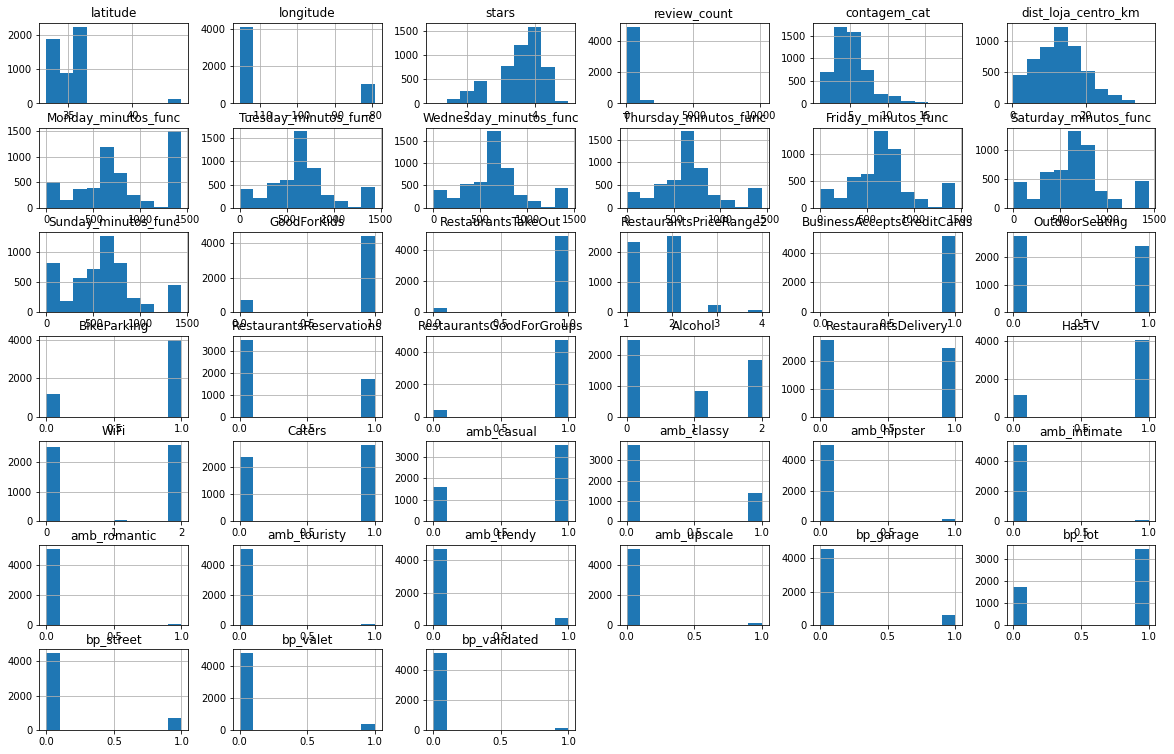

In [90]:
df_eda.hist(figsize=(20,13));

## 2.2 Correlação

### 2.2.0 Heatmap de correlação

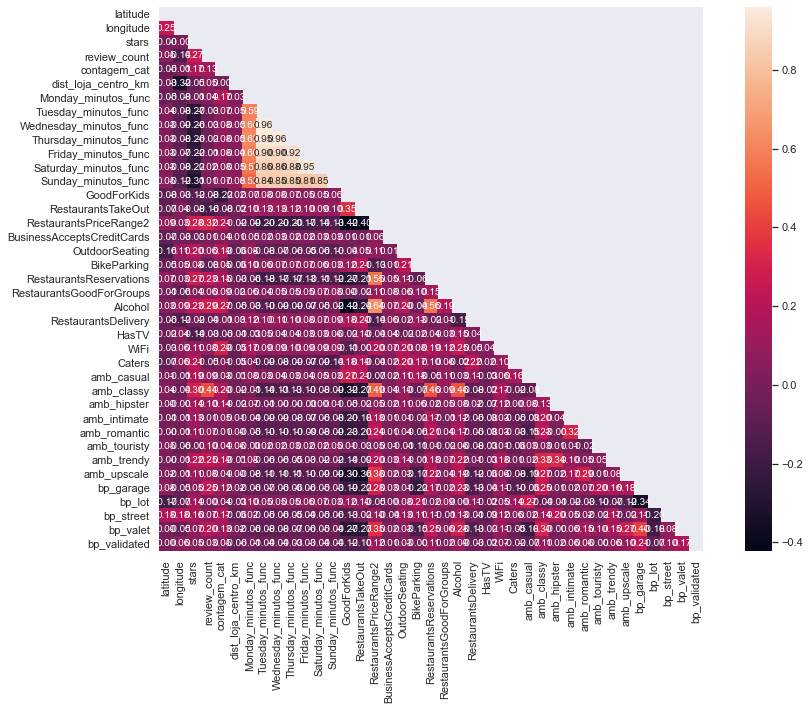

In [91]:
corrmat = df_eda.corr()
sns.set(font_scale=1.0)
f, ax = plt.subplots(figsize=(15, 10))
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corrmat, dtype=bool))
hm = sns.heatmap(corrmat, 
                 mask=mask,
                 cbar=True, # formatando a barra lateral de cores para o heatmap
                 annot=True, 
                 square=True, 
                 fmt='.2f', 
                 annot_kws={'size': 10}, 
                 yticklabels=corrmat.columns, 
                 xticklabels=corrmat.columns)

### 2.2.1 Lista de correlações

In [92]:
corrmat_lower = (corrmat*~mask).replace({0.0:np.nan}).round(2)
corr_list = abs(corrmat_lower).stack(dropna=True)\
                              .reset_index()\
                              .rename({'level_0':'var_1','level_1':'var_2',0:'corr'}, axis=1)\
                              .sort_values(by='corr', ascending=False)\
                              .head(20)
corr_list

,var_1,var_2,corr
44,Thursday_minutos_func,Wednesday_minutos_func,0.96
35,Wednesday_minutos_func,Tuesday_minutos_func,0.96
65,Saturday_minutos_func,Friday_minutos_func,0.95
43,Thursday_minutos_func,Tuesday_minutos_func,0.95
54,Friday_minutos_func,Thursday_minutos_func,0.92
52,Friday_minutos_func,Tuesday_minutos_func,0.90
53,Friday_minutos_func,Wednesday_minutos_func,0.90
64,Saturday_minutos_func,Thursday_minutos_func,0.88
63,Saturday_minutos_func,Wednesday_minutos_func,0.86
62,Saturday_minutos_func,Tuesday_minutos_func,0.86


Podemos observar que podemos agrupar 3 features - os horários de funcionamento de 3a a 5a feira, devido à alta correlação entre elas.

## 2.3 Mapas

### 2.3.0 Plotagem de coordenadas; quanto mais escuro, maior a nota

In [93]:
df_eda['city'].unique()

<StringArray>
['Las Vegas', 'Scottsdale', 'Charlotte', 'Phoenix', 'Toronto']
Length: 5, dtype: string

#### 2.3.0.0 Plotagem - Las Vegas

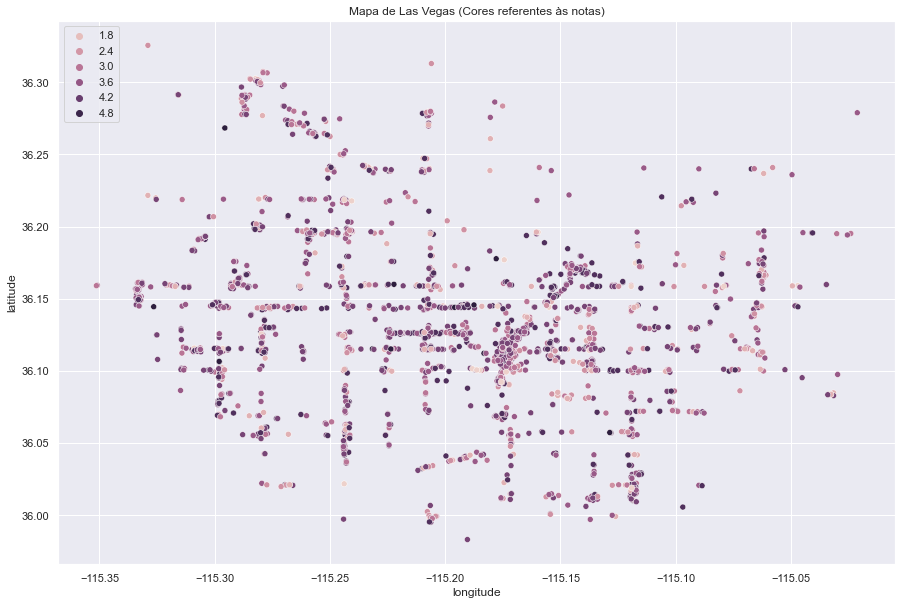

In [94]:
ls_longitude_lasvegas = -115.0
li_longitude_lasvegas = -115.4
ls_latitude_lasvegas = 36.35
li_latitude_lasvegas = 35.95

geo_lasvegas = df_eda.loc[(df_eda['city'] == 'Las Vegas') &
                       (df_eda['longitude'] > li_longitude_lasvegas) &
                       (df_eda['longitude'] < ls_longitude_lasvegas) &
                       (df_eda['latitude'] > li_latitude_lasvegas) &
                       (df_eda['latitude'] < ls_latitude_lasvegas),
                       ['stars', 'latitude','longitude']]

plt.figure(figsize=(15,10))
plt.title('Mapa de Las Vegas (Cores referentes às notas)')
sns.scatterplot(x=geo_lasvegas['longitude'], y=geo_lasvegas['latitude'], hue=geo_lasvegas['stars'].tolist())
plt.show()

#### 2.3.0.1 Plotagem - Scottsdale

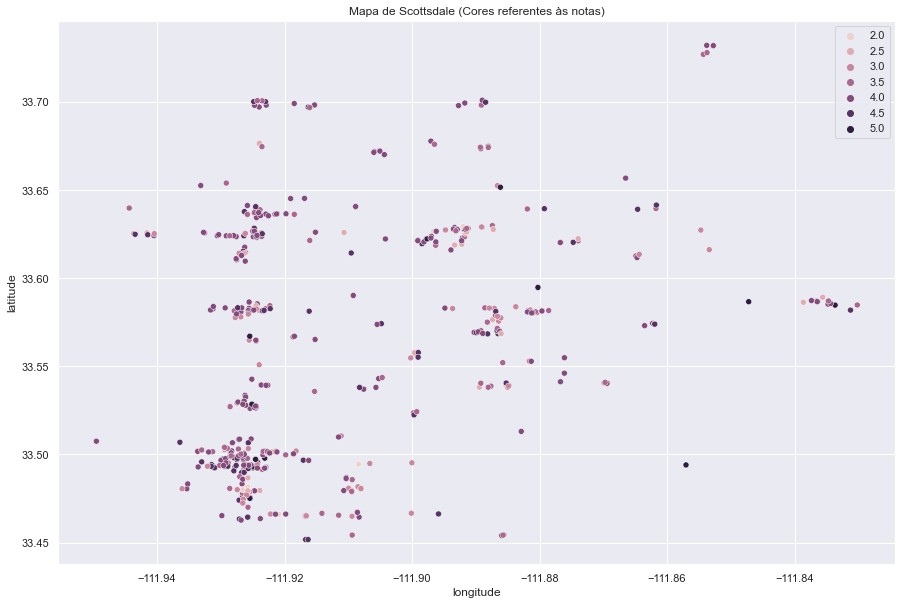

In [95]:
ls_longitude_scottsdale = -111.825
li_longitude_scottsdale = -111.95
ls_latitude_scottsdale = 33.74
li_latitude_scottsdale = 33.4

geo_scottsdale = df_eda.loc[(df_eda['city'] == 'Scottsdale') &
                       (df_eda['longitude'] > li_longitude_scottsdale) &
                       (df_eda['longitude'] < ls_longitude_scottsdale) &
                       (df_eda['latitude'] > li_latitude_scottsdale) &
                       (df_eda['latitude'] < ls_latitude_scottsdale),
                       ['stars', 'latitude','longitude']]

plt.figure(figsize=(15,10))
plt.title('Mapa de Scottsdale (Cores referentes às notas)')
sns.scatterplot(x=geo_scottsdale['longitude'], y=geo_scottsdale['latitude'], hue=geo_scottsdale['stars'].tolist())
plt.show()

#### 2.3.0.2 Plotagem - Charlotte

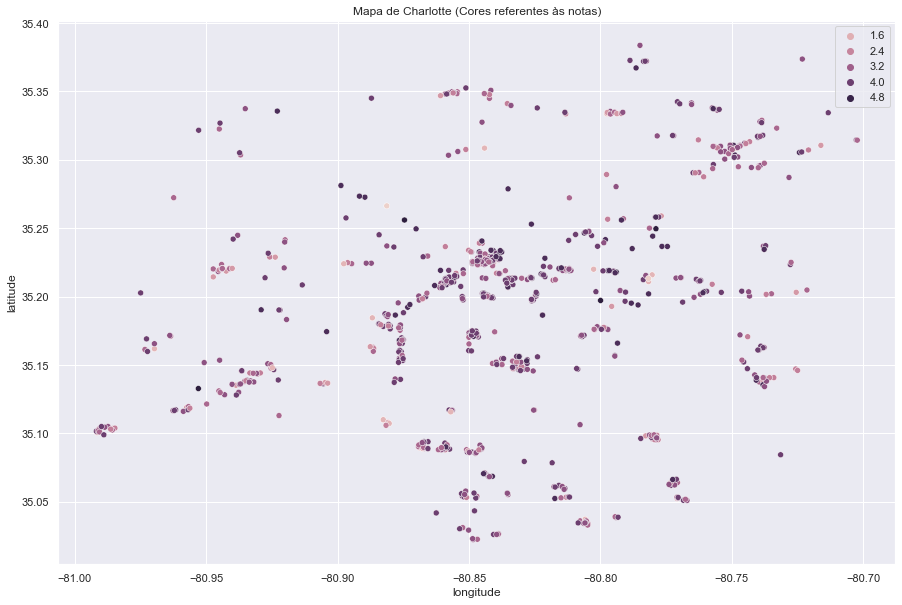

In [96]:
ls_longitude_charlotte = -80.7
li_longitude_charlotte = -81.0
ls_latitude_charlotte = 35.4
li_latitude_charlotte = 35.0

geo_charlotte = df_eda.loc[(df_eda['city'] == 'Charlotte') &
                       (df_eda['longitude'] > li_longitude_charlotte) &
                       (df_eda['longitude'] < ls_longitude_charlotte) &
                       (df_eda['latitude'] > li_latitude_charlotte) &
                       (df_eda['latitude'] < ls_latitude_charlotte),
                       ['stars', 'latitude','longitude']]

plt.figure(figsize=(15,10))
plt.title('Mapa de Charlotte (Cores referentes às notas)')
sns.scatterplot(x=geo_charlotte['longitude'], y=geo_charlotte['latitude'], hue=geo_charlotte['stars'].tolist())
plt.show()

#### 2.3.0.3 Plotagem - Phoenix

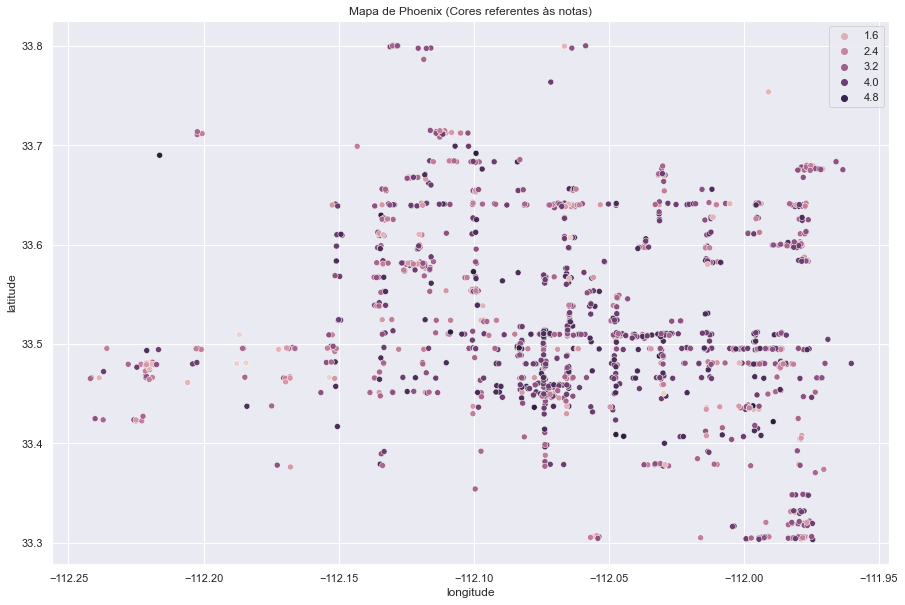

In [97]:
ls_longitude_phoenix = -111.95
li_longitude_phoenix = -112.25
ls_latitude_phoenix = 37.73
li_latitude_phoenix = 33.29

geo_phoenix = df_eda.loc[(df_eda['city'] == 'Phoenix') &
                       (df_eda['longitude'] > li_longitude_phoenix) &
                       (df_eda['longitude'] < ls_longitude_phoenix) &
                       (df_eda['latitude'] > li_latitude_phoenix) &
                       (df_eda['latitude'] < ls_latitude_phoenix),
                       ['stars', 'latitude','longitude']]

plt.figure(figsize=(15,10))
plt.title('Mapa de Phoenix (Cores referentes às notas)')
sns.scatterplot(x=geo_phoenix['longitude'], y=geo_phoenix['latitude'], hue=geo_phoenix['stars'].tolist())
plt.show()

#### 2.3.0.4 Plotagem - Toronto

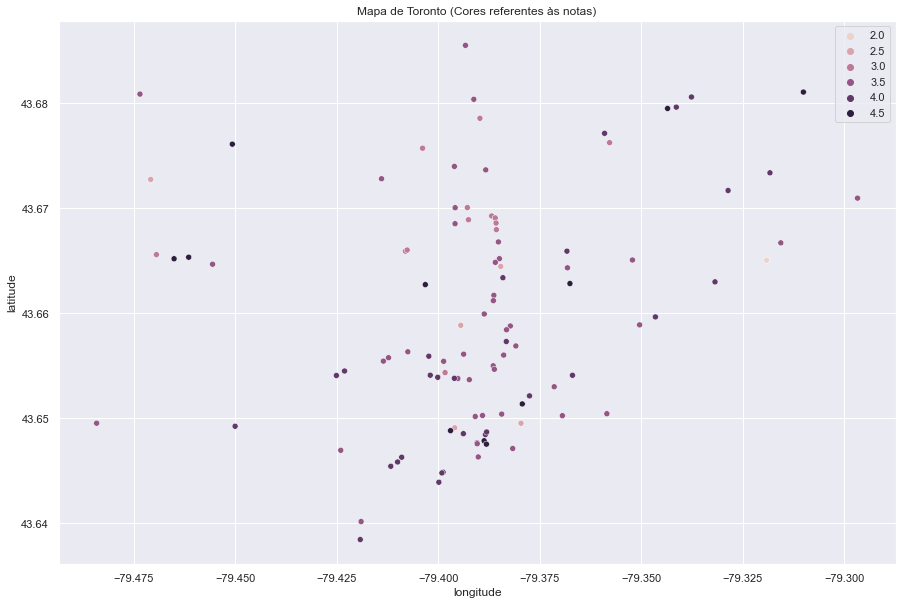

In [98]:
ls_longitude_toronto = -79.27
li_longitude_toronto = -79.50
ls_latitude_toronto = 43.69
li_latitude_toronto = 43.63

geo_toronto = df_eda.loc[(df_eda['city'] == 'Toronto') &
                       (df_eda['longitude'] > li_longitude_toronto) &
                       (df_eda['longitude'] < ls_longitude_toronto) &
                       (df_eda['latitude'] > li_latitude_toronto) &
                       (df_eda['latitude'] < ls_latitude_toronto),
                       ['stars', 'latitude','longitude']]

plt.figure(figsize=(15,10))
plt.title('Mapa de Toronto (Cores referentes às notas)')
sns.scatterplot(x=geo_toronto['longitude'], y=geo_toronto['latitude'], hue=geo_toronto['stars'].tolist())
plt.show()

### 2.3.1 Heatmap

In [99]:
m = folium.Map(location=[df_eda['latitude'].mean(), df_eda['longitude'].mean()])
folium.GeoJson('zipcode_king_county.geojson',name='geojson').add_to(m)
HeatMap(data=df_eda[['latitude', 'longitude', 'stars']].groupby(['latitude', 'longitude']).mean().reset_index().values.tolist(), radius=9, max_zoom=13).add_to(m)
m

# 3 MODELAGEM

No EDA vimos que os horários de funcionamento de 3a, 4a e 5a feira dos estabelecimentos são muito correlacionados. Por isso será criada uma coluna que conste a média dos 3 dias e assim os substitua.

Já podemos também eliminar todas variáveis categórias.

A coluna 'stars' é a variável target, e ela será substituída:
*   De 3.5 a 5.0 estrelas receberá o valor '1' e será um estabelecimento bem avaliado
*   Abaixo de 3.5 estrelas receberá o valor '0' e será um estabelecimento mal avaliado.

Nossa modelagem buscará prever se um estabelecimento será bem ou mal avaliado com base em suas features.

## 3.0 Alterações da base

In [100]:
# Criando nossa tabela a ser usada na modelagem
df_model = df_eda.copy()
df_model.head()

,city,state,postal_code,latitude,longitude,stars,review_count,contagem_cat,dist_loja_centro_km,Monday_minutos_func,...,amb_intimate,amb_romantic,amb_touristy,amb_trendy,amb_upscale,bp_garage,bp_lot,bp_street,bp_valet,bp_validated
0,Las Vegas,NV,89131,36.307495,-115.279059,2.5,37,2,8.323984,0,...,0,0,0,0,0,0,0,0,0,0
1,Scottsdale,AZ,85251,33.493775,-111.925933,3.5,720,5,22.184410,660,...,0,0,0,0,0,0,0,1,0,0
2,Charlotte,NC,28202,35.226911,-80.843823,5.0,172,4,2.428057,0,...,0,0,0,0,0,0,0,1,0,0
3,Scottsdale,AZ,85250,33.540451,-111.885229,4.5,35,3,16.383548,1440,...,0,0,0,0,0,0,0,0,0,0
4,Las Vegas,NV,89103,36.099361,-115.226636,4.0,141,4,15.265883,660,...,0,0,0,0,0,0,1,0,0,0


In [101]:
# Substituindo as 'stars'
df_model['stars'].loc[df_model['stars'] < 4.0] = 0
df_model['stars'].loc[df_model['stars'] >= 4.0] = 1
df_model['stars'] = df_model['stars'].astype('int')
df_model.head()


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,city,state,postal_code,latitude,longitude,stars,review_count,contagem_cat,dist_loja_centro_km,Monday_minutos_func,...,amb_intimate,amb_romantic,amb_touristy,amb_trendy,amb_upscale,bp_garage,bp_lot,bp_street,bp_valet,bp_validated
0,Las Vegas,NV,89131,36.307495,-115.279059,0,37,2,8.323984,0,...,0,0,0,0,0,0,0,0,0,0
1,Scottsdale,AZ,85251,33.493775,-111.925933,0,720,5,22.184410,660,...,0,0,0,0,0,0,0,1,0,0
2,Charlotte,NC,28202,35.226911,-80.843823,1,172,4,2.428057,0,...,0,0,0,0,0,0,0,1,0,0
3,Scottsdale,AZ,85250,33.540451,-111.885229,1,35,3,16.383548,1440,...,0,0,0,0,0,0,0,0,0,0
4,Las Vegas,NV,89103,36.099361,-115.226636,1,141,4,15.265883,660,...,0,0,0,0,0,0,1,0,0,0


In [114]:
df_model.stars.value_counts()

0    2797
1    2375
Name: stars, dtype: int64

In [102]:
df_model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5172 entries, 0 to 5171
Data columns (total 42 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   city                        5172 non-null   string 
 1   state                       5172 non-null   string 
 2   postal_code                 5172 non-null   string 
 3   latitude                    5172 non-null   float64
 4   longitude                   5172 non-null   float64
 5   stars                       5172 non-null   int32  
 6   review_count                5172 non-null   int32  
 7   contagem_cat                5172 non-null   int32  
 8   dist_loja_centro_km         5172 non-null   float64
 9   Monday_minutos_func         5172 non-null   int32  
 10  Tuesday_minutos_func        5172 non-null   int32  
 11  Wednesday_minutos_func      5172 non-null   int32  
 12  Thursday_minutos_func       5172 non-null   int32  
 13  Friday_minutos_func         5172 

In [103]:
# Excluindo as variáveis categóricas
df_model = df_model.drop(columns=['city', 'state', 'postal_code'])
df_model.columns

Index(['latitude', 'longitude', 'stars', 'review_count', 'contagem_cat',
       'dist_loja_centro_km', 'Monday_minutos_func', 'Tuesday_minutos_func',
       'Wednesday_minutos_func', 'Thursday_minutos_func',
       'Friday_minutos_func', 'Saturday_minutos_func', 'Sunday_minutos_func',
       'GoodForKids', 'RestaurantsTakeOut', 'RestaurantsPriceRange2',
       'BusinessAcceptsCreditCards', 'OutdoorSeating', 'BikeParking',
       'RestaurantsReservations', 'RestaurantsGoodForGroups', 'Alcohol',
       'RestaurantsDelivery', 'HasTV', 'WiFi', 'Caters', 'amb_casual',
       'amb_classy', 'amb_hipster', 'amb_intimate', 'amb_romantic',
       'amb_touristy', 'amb_trendy', 'amb_upscale', 'bp_garage', 'bp_lot',
       'bp_street', 'bp_valet', 'bp_validated'],
      dtype='object')

In [104]:
# Criando coluna de horário de funcionamento médio de 3a a 5a
df_model['Tu_We_Th_minutos_func'] = (df_model['Tuesday_minutos_func'] + df_model['Wednesday_minutos_func'] + df_model['Thursday_minutos_func']) / 3
df_model = df_model.drop(columns = ['Tuesday_minutos_func', 'Wednesday_minutos_func', 'Thursday_minutos_func'])
df_model.head()

,latitude,longitude,stars,review_count,contagem_cat,dist_loja_centro_km,Monday_minutos_func,Friday_minutos_func,Saturday_minutos_func,Sunday_minutos_func,...,amb_romantic,amb_touristy,amb_trendy,amb_upscale,bp_garage,bp_lot,bp_street,bp_valet,bp_validated,Tu_We_Th_minutos_func
0,36.307495,-115.279059,0,37,2,8.323984,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.0
1,33.493775,-111.925933,0,720,5,22.184410,660,780,780,660,...,0,0,0,0,0,0,1,0,0,660.0
2,35.226911,-80.843823,1,172,4,2.428057,0,210,0,0,...,0,0,0,0,0,0,1,0,0,210.0
3,33.540451,-111.885229,1,35,3,16.383548,1440,360,600,480,...,0,0,0,0,0,0,0,0,0,480.0
4,36.099361,-115.226636,1,141,4,15.265883,660,660,660,660,...,0,0,0,0,0,1,0,0,0,660.0


In [105]:
# Vendo as colunas para organizar
df_model.columns

Index(['latitude', 'longitude', 'stars', 'review_count', 'contagem_cat',
       'dist_loja_centro_km', 'Monday_minutos_func', 'Friday_minutos_func',
       'Saturday_minutos_func', 'Sunday_minutos_func', 'GoodForKids',
       'RestaurantsTakeOut', 'RestaurantsPriceRange2',
       'BusinessAcceptsCreditCards', 'OutdoorSeating', 'BikeParking',
       'RestaurantsReservations', 'RestaurantsGoodForGroups', 'Alcohol',
       'RestaurantsDelivery', 'HasTV', 'WiFi', 'Caters', 'amb_casual',
       'amb_classy', 'amb_hipster', 'amb_intimate', 'amb_romantic',
       'amb_touristy', 'amb_trendy', 'amb_upscale', 'bp_garage', 'bp_lot',
       'bp_street', 'bp_valet', 'bp_validated', 'Tu_We_Th_minutos_func'],
      dtype='object')

In [106]:
# Organizando as informações e colocando a variável target em primeiro lugar da coluna
df_model = df_model[['stars', 'RestaurantsPriceRange2', 'review_count', 'contagem_cat', 'latitude', 'longitude', 'dist_loja_centro_km',
                     'Sunday_minutos_func', 'Monday_minutos_func', 'Tu_We_Th_minutos_func', 'Friday_minutos_func', 'Saturday_minutos_func',
                     'RestaurantsDelivery', 'RestaurantsTakeOut', 'RestaurantsGoodForGroups', 'RestaurantsReservations','BusinessAcceptsCreditCards',
                     'OutdoorSeating','HasTV', 'WiFi', 'Caters', 'Alcohol', 'GoodForKids',
                     'amb_casual', 'amb_classy', 'amb_hipster', 'amb_intimate', 'amb_romantic', 'amb_touristy', 'amb_trendy', 'amb_upscale',
                     'BikeParking', 'bp_garage', 'bp_lot', 'bp_street', 'bp_valet', 'bp_validated',]]
df_model.head()

,stars,RestaurantsPriceRange2,review_count,contagem_cat,latitude,longitude,dist_loja_centro_km,Sunday_minutos_func,Monday_minutos_func,Tu_We_Th_minutos_func,...,amb_romantic,amb_touristy,amb_trendy,amb_upscale,BikeParking,bp_garage,bp_lot,bp_street,bp_valet,bp_validated
0,0,1,37,2,36.307495,-115.279059,8.323984,0,0,0.0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,720,5,33.493775,-111.925933,22.184410,660,660,660.0,...,0,0,0,0,1,0,0,1,0,0
2,1,1,172,4,35.226911,-80.843823,2.428057,0,0,210.0,...,0,0,0,0,1,0,0,1,0,0
3,1,1,35,3,33.540451,-111.885229,16.383548,480,1440,480.0,...,0,0,0,0,1,0,0,0,0,0
4,1,1,141,4,36.099361,-115.226636,15.265883,660,660,660.0,...,0,0,0,0,0,0,1,0,0,0


In [107]:
df_model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5172 entries, 0 to 5171
Data columns (total 37 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   stars                       5172 non-null   int32  
 1   RestaurantsPriceRange2      5172 non-null   int32  
 2   review_count                5172 non-null   int32  
 3   contagem_cat                5172 non-null   int32  
 4   latitude                    5172 non-null   float64
 5   longitude                   5172 non-null   float64
 6   dist_loja_centro_km         5172 non-null   float64
 7   Sunday_minutos_func         5172 non-null   int32  
 8   Monday_minutos_func         5172 non-null   int32  
 9   Tu_We_Th_minutos_func       5172 non-null   float64
 10  Friday_minutos_func         5172 non-null   int32  
 11  Saturday_minutos_func       5172 non-null   int32  
 12  RestaurantsDelivery         5172 non-null   int32  
 13  RestaurantsTakeOut          5172 

In [108]:
df_model.shape

(5172, 37)

## 3.1 Criando o Modelo

 * Criando um modelo com todas as features
 

In [162]:
# Separando variável target das preditoras
y = df_model['stars']
X = df_model[['review_count', 'Tu_We_Th_minutos_func', 'Friday_minutos_func', 'Sunday_minutos_func', 'amb_classy', 'Saturday_minutos_func', 'bp_lot', 'Caters', 'bp_street', 'RestaurantsReservations', 'Alcohol', 'latitude', 'Monday_minutos_func', 'longitude', 'HasTV', 'dist_loja_centro_km','WiFi', 'amb_trendy', 'RestaurantsPriceRange2']]


In [163]:

X


,review_count,Tu_We_Th_minutos_func,Friday_minutos_func,Sunday_minutos_func,amb_classy,Saturday_minutos_func,bp_lot,Caters,bp_street,RestaurantsReservations,Alcohol,latitude,Monday_minutos_func,longitude,HasTV,dist_loja_centro_km,WiFi,amb_trendy,RestaurantsPriceRange2
0,37,0.0,0,0,0,0,0,0,0,0,0,36.307495,0,-115.279059,1,8.323984,0,0,1
1,720,660.0,780,660,0,780,0,0,1,0,0,33.493775,660,-111.925933,0,22.184410,0,0,1
2,172,210.0,210,0,0,0,0,1,1,0,0,35.226911,0,-80.843823,1,2.428057,0,0,1
3,35,480.0,360,480,0,600,0,1,0,0,0,33.540451,1440,-111.885229,1,16.383548,2,0,1
4,141,660.0,660,660,0,660,1,1,0,0,0,36.099361,660,-115.226636,1,15.265883,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5167,269,630.0,690,660,1,690,0,1,0,1,2,35.145671,630,-80.825569,1,6.929005,2,0,3
5168,104,660.0,660,420,0,660,0,1,1,1,1,43.700617,660,-79.396762,1,4.940673,2,0,2
5169,69,180.0,180,0,0,0,1,1,1,0,0,36.076518,180,-115.153343,0,20.108011,0,0,1
5170,106,0.0,0,0,0,0,1,1,0,0,2,33.479139,0,-112.221142,1,16.031045,0,0,2


In [164]:
X.amb_classy.value_counts()

0    3786
1    1386
Name: amb_classy, dtype: int64

In [111]:
y.value_counts()

0    2797
1    2375
Name: stars, dtype: int64

### 3.1.1 Fazendo balanceamento da variavel target

* Aplicando o Método over_sampling e under_sampling juntos para atrair um melhor desempenho 


### 3.1.2 Normalizando os Dados Com MinMaxScaler

In [112]:

# scaler = MinMaxScaler(feature_range = (0,1))
# scaler_df =  scaler.fit_transform(X)
# scaler.inverse_transform(scaler_df)

### 3.1.2 Normalizando os Dados com StandardScaler

In [165]:

normalizar = preprocessing.StandardScaler().fit(X)
x_norm = normalizar.transform(X)

* Aplicando a normalização com StandardScaler o modelo teve uma performance melhor

### 3.1.3 Transformando os dados para o  componentes PCA

In [ ]:
# definindo a quantidades de componentes
pca= PCA(n_components=2)#[4,10,18] ruducao de 50%,75% e 90% da dimensão
#aplicando a transformacao
x_pca = pca.fit_transform(x_norm)



###  3.1.3 Separando os Dados de treino e de teste

In [166]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x_norm, y, test_size=0.3, random_state=7)


In [167]:
# instanciando o over e o under
over = RandomOverSampler(sampling_strategy=0.45)
under = RandomUnderSampler(sampling_strategy=0.7)


# aplicando a transformação over sampler
X_over, y_over = over.fit_resample(x_train, y_train)
# summarize class distribution
print(f"Oversampled: {Counter(y_over)}")



# aplicando a transformação de under sampler
X_under, y_under = under.fit_resample(X_over, y_over)

# summarize class distribution
print(f"UnderSampling: {Counter(y_under)}")

ValueError: The specified ratio required to remove samples from the minority class while trying to generate new samples. Please increase the ratio.

#### Alterando a quantidade de balanceamento para 70/70

In [ ]:
# instanciando o over e o under
over_1 = RandomOverSampler(sampling_strategy=0.7)
under_1= RandomUnderSampler(sampling_strategy=0.7)


# aplicando a transformação over sampler
X_over_1, y_over_1 = over_1.fit_resample(x_train, y_train)
# summarize class distribution
print(f"Oversampled: {Counter(y_over_1)}")



# aplicando a transformação de under sampler
X_under_1, y_under_1 = under_1.fit_resample(X_over_1, y_over_1)

# summarize class distribution
print(f"UnderSampling: {Counter(y_under_1)}")

#### Fazendo o balanceamento de 60/70

In [ ]:
# instanciando o over e o under
over_2 = RandomOverSampler(sampling_strategy=0.6)
under_2= RandomUnderSampler(sampling_strategy=0.7)


# aplicando a transformação over sampler
X_over_2, y_over_2 = over_2.fit_resample(x_train, y_train)
# summarize class distribution
print(f"Oversampled: {Counter(y_over_2)}")



# aplicando a transformação de under sampler
X_under_2, y_under_2 = under_2.fit_resample(X_over_2, y_over_2)

# summarize class distribution
print(f"UnderSampling: {Counter(y_under_2)}")

#### Fazendo o balanceamento de 65/70

In [ ]:
# instanciando o over e o under
over_3 = RandomOverSampler(sampling_strategy=0.65)
under_3= RandomUnderSampler(sampling_strategy=0.7)


# aplicando a transformação over sampler
X_over_3, y_over_3 = over_2.fit_resample(x_train, y_train)
# summarize class distribution
print(f"Oversampled: {Counter(y_over_3)}")



# aplicando a transformação de under sampler
X_under_3, y_under_3 = under_2.fit_resample(X_over_3, y_over_3)

# summarize class distribution
print(f"UnderSampling: {Counter(y_under_3)}")

####  Fazendo balanceando de 50/70

In [ ]:
# instanciando o over e o under
over_4 = RandomOverSampler(sampling_strategy=0.5)
under_4= RandomUnderSampler(sampling_strategy=0.7)


# aplicando a transformação over sampler
X_over_4, y_over_4 = over_4.fit_resample(x_train, y_train)
# summarize class distribution
print(f"Oversampled: {Counter(y_over_4)}")



# aplicando a transformação de under sampler
X_under_4, y_under_4 = under_4.fit_resample(X_over_4, y_over_4)

# summarize class distribution
print(f"UnderSampling: {Counter(y_under_4)}")

#### Fazendo o Balanceamento de 55/80

In [ ]:
# instanciando o over e o under
over_5 = RandomOverSampler(sampling_strategy=0.55)
under_5= RandomUnderSampler(sampling_strategy=0.8)


# aplicando a transformação over sampler
X_over_5, y_over_5 = over_5.fit_resample(x_train, y_train)
# summarize class distribution
print(f"Oversampled: {Counter(y_over_5)}")



# aplicando a transformação de under sampler
X_under_5, y_under_5 = under_5.fit_resample(X_over_5, y_over_5)

# summarize class distribution
print(f"UnderSampling: {Counter(y_under_5)}")

* Quando balanceamenos 70% da classe do valor da classe minoritaria a classe majoritaria, temos um reducao  em overfitting

#### 100% da classe majoritaria

In [168]:
# instanciando o over  - igualando a classe menor a classe maior
over_6 = RandomOverSampler(sampling_strategy='minority')

# aplicando a transformação over sampler
X_over_6, y_over_6 = over_6.fit_resample(x_train, y_train)
# summarize class distribution
print(f"Oversampled: {Counter(y_over_6)}")



Oversampled: Counter({1: 1966, 0: 1966})


#### 100% da classe minoritaria 

In [118]:
# instanciando o under  - igualando a classe maior a classe menor
under_7 = RandomUnderSampler(sampling_strategy='majority')

# aplicando a transformação over sampler
X_under_7, y_under_7 = under_7.fit_resample(x_train, y_train)
# summarize class distribution
print(f"Oversampled: {Counter(y_under_7)}")



Oversampled: Counter({0: 1654, 1: 1654})


### Função Para definir os niveis de folds e calculo da média para validação cruzada

In [119]:
#  definiando o nivel de folds
cv = StratifiedKFold(n_splits = 10, shuffle = True)

# criando uma funca para ver a media da acuracia e o seu intervalo
def intervalo(results):
    mean = results.mean()
    data = results.std()
    print('Acurácia média: {:.2f}%'.format(mean*100))
    print('Intervalo de acurácia: [{:.2f}% ~ {:.2f}%]'
           .format((mean - 2*data)*100, (mean + 2*data)*100))

    return intervalo




###  3.1.4 Aplicando os Os Algóritmos Classificação¶

## Random Forest Classifier


### Treinando o modelo

In [169]:
randomForestClassifer = RandomForestClassifier(max_depth=50, n_estimators=100, max_samples=50, random_state=20, n_jobs=-1 )

In [170]:
#aplicando ajustes simples no modelo
#random_class_1 = RandomForestClassifier(n_estimators=100, criterion='gini', max_depth=1, min_samples_split=2, min_samples_leaf= 1, n_jobs=-1 )

In [171]:
randomForestClassifer.fit(X_over_6, y_over_6)

RandomForestClassifier(max_depth=50, max_samples=50, n_jobs=-1, random_state=20)

### Predição do modelo

In [172]:
# com os dados de treino
predicao_random_train = randomForestClassifer.predict(X_over_6)
predicao_random_train

array([1, 0, 1, ..., 1, 0, 1])

In [173]:
# com os dados de teste
predicao_random_test = randomForestClassifer.predict(x_test)
predicao_random_test

array([1, 1, 1, ..., 0, 1, 0])


### Avaliando o modelo com  f1_score

In [174]:
# Verificando a média de f1_score dos dados de treino e teste
metrica_train_random = []
metrica_test_random = []
metrica_train_random.append(f1_score(y_over_6, predicao_random_train, average='micro'))
metrica_test_random.append(f1_score(y_test, predicao_random_test, average='micro'))

metrica_final_test_random = []
metrica_final_train_random = []
metrica_final_test_random.append(np.mean(metrica_test_random))
metrica_final_train_random.append(np.mean(metrica_train_random))
        

In [175]:

# calculando a diferenca entrer as métricas de treino e teste
diff_metrica_random= []
diff_final_metrica_random = []
diff_metrica_random.append(100*np.abs((f1_score(y_over_6, predicao_random_train, average='micro') - \
                                   f1_score(y_test, predicao_random_test, average='micro'))/\
                                  f1_score(y_test, predicao_random_test, average='micro')))
   
diff_final_metrica_random.append(np.mean(diff_metrica_random))

In [176]:
print(metrica_final_train_random)
print("\n------------------------------\n")
print(metrica_final_test_random)

[0.7263479145473042]

------------------------------

[0.7132731958762887]


In [177]:
print('diferença do f1_score das métricas de treino e teste=', diff_final_metrica_random)

diferença do f1_score das métricas de treino e teste= [1.8330590223501413]


### Analisando  a performance




### Matriz de Confusão

In [141]:
# avaliando com os dados de treino
matris_random= pd.crosstab(y_over_6, predicao_random_train, rownames=['Real'], colnames=['Predito'], margins=True)
matris_random


Predito,0,1,All
Real,,,
0,1454,512,1966
1,587,1379,1966
All,2041,1891,3932


In [142]:
# avaliando com os dados de teste
matris_random_test= pd.crosstab(y_test, predicao_random_test, rownames=['Real'], colnames=['Predito'], margins=True)
matris_random_test


Predito,0,1,All
Real,,,
0,584,247,831
1,212,509,721
All,796,756,1552



### Relatório de Classificação

In [143]:
#avaliando com os dados de traino
resultado_random_train = classification_report(y_over_6, predicao_random_train)
print(resultado_random_train)

              precision    recall  f1-score   support

           0       0.71      0.74      0.73      1966
           1       0.73      0.70      0.72      1966

    accuracy                           0.72      3932
   macro avg       0.72      0.72      0.72      3932
weighted avg       0.72      0.72      0.72      3932



In [144]:
#avaliando com os dados de teste
resultado_random_test = classification_report(y_test, predicao_random_test)
print(resultado_random_test)

              precision    recall  f1-score   support

           0       0.73      0.70      0.72       831
           1       0.67      0.71      0.69       721

    accuracy                           0.70      1552
   macro avg       0.70      0.70      0.70      1552
weighted avg       0.71      0.70      0.70      1552



### Features importantes

In [145]:
 randomForestClassifer.feature_importances_

array([0.0159384 , 0.13206746, 0.06562176, 0.07508516, 0.06969759,
       0.07125593, 0.07057054, 0.03788421, 0.06341842, 0.06830694,
       0.06031709, 0.01587652, 0.00647922, 0.00678578, 0.01632739,
       0.00178589, 0.01110133, 0.01185292, 0.01695667, 0.01604428,
       0.02177306, 0.0068586 , 0.0098514 , 0.03690161, 0.00040539,
       0.00023715, 0.00040735, 0.00230852, 0.00974384, 0.00211253,
       0.01398972, 0.00964727, 0.02240809, 0.02046686, 0.00699935,
       0.00251576])

In [146]:

features_random= pd.DataFrame(randomForestClassifer.feature_importances_, index=X.columns,
                                    columns=['importance']).sort_values('importance', ascending= False)
features_random

,importance
review_count,0.132067
latitude,0.075085
dist_loja_centro_km,0.071256
Sunday_minutos_func,0.070571
longitude,0.069698
Friday_minutos_func,0.068307
contagem_cat,0.065622
Tu_We_Th_minutos_func,0.063418
Saturday_minutos_func,0.060317
Monday_minutos_func,0.037884


### Shap 
  A contruibuição de cada feature para o modelo quanto positivo como negativamente

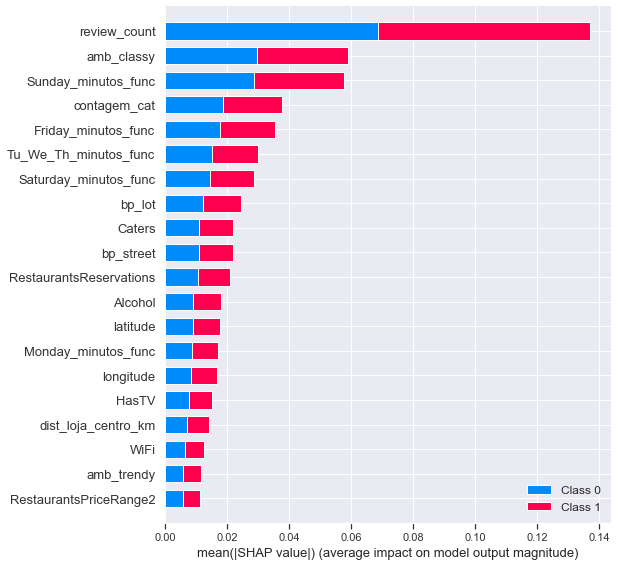

In [156]:
features= shap.TreeExplainer(randomForestClassifer)
shap_values = features.shap_values(X_over_6, y, )
shap.summary_plot(shap_values, X)

### Plotando o gráfico das mais importantes para as menos importantes

In [ ]:
importances_random =  randomForestClassifer.feature_importances_
indices = np.argsort(importances_random)[::-1]
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances_random[indices[f]]))
f, ax = plt.subplots(figsize=(11, 9))
plt.title("Feature ranking", fontsize = 20)
plt.bar(range(X.shape[1]), importances_random[indices],
    color="b", 
    align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.ylabel("importance", fontsize = 18)
plt.xlabel("index of the feature", fontsize = 18)
plt.show()

#Indice das features
# review_count = 1
# WheelchairAccessible =2
#RestaurantsGoodForGroups = 3 
#latitude =3
# Longitude = 4
# Alcohol = 5
# NoiseLevel = 6


### Aplicando Cross_Validation


In [ ]:
# avaliando a acurácia  com os dado de traino
valid_random = cross_val_score(randomForestClassifer,x_train,y_train, cv=cv, scoring= 'accuracy')
intervalo(valid_random)

In [ ]:
# verificando a acurácia  com os dado de teste
valid_random_test = cross_val_score(randomForestClassifer,x_test,y_test, cv=cv, scoring= 'accuracy')
intervalo(valid_random_test)


### Matriz de confusão da validação cruzada

In [ ]:
# avaliando com os dados de treino 
matriz_pred_random = cross_val_predict(randomForestClassifer, x_train, y_train, cv = cv)

fig, ax = plt.subplots()
sns.heatmap(confusion_matrix(y_train, matriz_pred_random), annot=True, 
            ax=ax, fmt='d', cmap='Reds')
ax.set_title("Matriz de Confusão", fontsize=18)
ax.set_ylabel("Real")
ax.set_xlabel("Predito")
plt.tight_layout()

In [ ]:
# avaliando com os dados de teste
matriz_pred_random_test = cross_val_predict(randomForestClassifer, x_test, y_test, cv = cv)

fig, ax = plt.subplots()
sns.heatmap(confusion_matrix(y_test, matriz_pred_random_test), annot=True, 
            ax=ax, fmt='d', cmap='Reds')
ax.set_title("Matriz de Confusão", fontsize=18)
ax.set_ylabel("Real")
ax.set_xlabel("Predito")
plt.tight_layout()


### Relatório de Classificação da validação cruzada

In [ ]:
# avaliando com os dados de treino
resultado_valid_random = classification_report(y_train, matriz_pred_random)
print(resultado_valid_random)

In [ ]:
# avaliando com os dados de teste
resultado_valid_random_test = classification_report(y_test, matriz_pred_random_test)
print(resultado_valid_random_test)

### Calculando o f1 score da validação cruzada

In [ ]:
#aplicando aos dado de treino
scores_train_random = cross_val_score(
    randomForestClassifer, x_train, y_train, cv=10, scoring='f1_micro')
scores_train_random

In [ ]:
median_random_score_train = scores_train_random.mean()
median_random_score_train

In [ ]:

scores_test_random = cross_val_score(
    randomForestClassifer, x_test, y_test, cv=10, scoring='f1_micro')
scores_test_random

In [ ]:
median_random_score_teste = scores_test_random.mean()
median_random_score_teste

In [ ]:
# avaliando a diferença  entre os dados validados de treino e de teste
diferenca_random = median_random_score_train - median_random_score_teste

In [ ]:
print('diferença do f1_score das métricas de treino e teste tem um overfiting  =', diferenca_random.sum()*100,  '%')

In [ ]:
# parametros utilizados
randomForestClassifer.get_params()

## Extra Tree Classifier


### Treinando o modelo

In [ ]:
modelo_tree_extra = ExtraTreesClassifier(max_depth=5,n_estimators=100, random_state=20)#[100.150.200]

In [ ]:
modelo_tree_extra.fit(x_train, y_train)

### Predição do modelo

In [ ]:
# com os dados de treino
predicao_extra_train = modelo_tree_extra.predict(x_train)
predicao_extra_train

In [ ]:
# com os dados de teste
predicao_extra_test = modelo_tree_extra.predict(x_test)
predicao_extra_test


### Avaliando o modelo com  f1_score

In [ ]:
# Verificando a média de f1_score dos dados de treino e teste
metrica_train_extra = []
metrica_test_extra = []
metrica_train_extra.append(f1_score(y_train, predicao_extra_train, average='micro'))
metrica_test_extra.append(f1_score(y_test, predicao_extra_test, average='micro'))

metrica_final_test_extra = []
metrica_final_train_extra = []
metrica_final_test_extra.append(np.mean(metrica_test_extra))
metrica_final_train_extra.append(np.mean(metrica_train_extra))
        

In [ ]:
# calculando a diferenca entrer as métricas de treino e teste
diff_metrica_extra= []
diff_final_metrica_extra = []
diff_metrica_extra.append(100*np.abs((f1_score(y_train, predicao_extra_train, average='micro') - \
                                   f1_score(y_test, predicao_extra_test, average='micro'))/\
                                  f1_score(y_test, predicao_extra_test, average='micro')))
   
diff_final_metrica_extra.append(np.mean(diff_metrica_extra))

In [ ]:
print(metrica_final_train_extra)
print("\n------------------------------\n")
print(metrica_final_test_extra)

In [ ]:

print('diferença do f1_score das métricas de treino e teste=', diff_final_metrica_extra)

### Analisando  a performance




### Matriz de Confusão

In [ ]:
# avaliando com os dados de treino
matris_extra= pd.crosstab(y_train, predicao_extra_train, rownames=['Real'], colnames=['Predito'], margins=True)
matris_extra


In [ ]:
# avaliando com os dados de teste
matris_extra_test= pd.crosstab(y_test, predicao_extra_test, rownames=['Real'], colnames=['Predito'], margins=True)
matris_extra_test



### Relatório de Classificação

In [ ]:
#avaliando com os dados de traino
resultado_extra_train = classification_report(y_train, predicao_extra_train)
print(resultado_extra_train)

In [ ]:
#avaliando com os dados de teste
resultado_extra_test = classification_report(y_test, predicao_extra_test)
print(resultado_extra_test)

### Features importantes

In [ ]:
modelo_tree_extra.feature_importances_

In [ ]:
# Criando um dataframe com as features importantes e seus scores:

features_extra = pd.DataFrame(modelo_tree_extra.feature_importances_, index=X.columns,
                                    columns=['importance']).sort_values('importance', ascending= False)
features_extra

### SHAP

In [ ]:
feature_2= shap.TreeExplainer(modelo_tree_extra)
shap_values = feature_2.shap_values(x_train)
shap.summary_plot(shap_values, X)

### Plotando o gráfico das mais importantes para as menos importantes

In [ ]:
importances_extra =  modelo_tree_extra.feature_importances_
indices = np.argsort(importances_extra)[::-1]
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances_extra[indices[f]]))
f, ax = plt.subplots(figsize=(11, 9))
plt.title("Feature ranking", fontsize = 20)
plt.bar(range(X.shape[1]), importances_extra[indices],
    color="b", 
    align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.ylabel("importance", fontsize = 18)
plt.xlabel("index of the feature", fontsize = 18)
plt.show()

#Indice das features
# review_count = 1
# WheelchairAccessible =2
#RestaurantsGoodForGroups = 3 
#latitude =3
# Longitude = 4
# Alcohol = 5
# NoiseLevel = 6


### Aplicando Cross_Validation


In [ ]:
# avaliando a acurácia  com os dado de traino
valid_extra = cross_val_score(modelo_tree_extra,x_train,y_train, cv=cv, scoring= 'accuracy')
intervalo(valid_extra)

In [ ]:
# verificando a acurácia  com os dado de teste
valid_extra_test = cross_val_score(modelo_tree_extra,x_test,y_test, cv=cv, scoring= 'accuracy')
intervalo(valid_extra_test)


### Matriz de confusão da validação cruzada

In [ ]:
# avaliando com os dados de treino 
matriz_pred_extra = cross_val_predict(modelo_tree_extra, x_train, y_train, cv = cv)

fig, ax = plt.subplots()
sns.heatmap(confusion_matrix(y_train, matriz_pred_extra), annot=True, 
            ax=ax, fmt='d', cmap='Reds')
ax.set_title("Matriz de Confusão", fontsize=18)
ax.set_ylabel("Real")
ax.set_xlabel("Predito")
plt.tight_layout()

In [ ]:
# avaliando com os dados de teste
matriz_pred_extra_test = cross_val_predict(modelo_tree_extra, x_test, y_test, cv = cv)

fig, ax = plt.subplots()
sns.heatmap(confusion_matrix(y_test, matriz_pred_extra_test), annot=True, 
            ax=ax, fmt='d', cmap='Reds')
ax.set_title("Matriz de Confusão", fontsize=18)
ax.set_ylabel("Real")
ax.set_xlabel("Predito")
plt.tight_layout()


### Relatório de Classificação da validação cruzada

In [ ]:
# avaliando com os dados de treino
resultado_valid_extra = classification_report(y_train, matriz_pred_extra)
print(resultado_valid_extra)

In [ ]:
# avaliando com os dados de teste
resultado_valid_extra_test = classification_report(y_test, matriz_pred_extra_test)
print(resultado_valid_extra_test)

### Calculando o f1 score da validação cruzada

In [ ]:
#aplicando aos dado de treino
scores_train_extra = cross_val_score(
    modelo_tree_extra, x_train, y_train, cv=cv, scoring='f1_micro')
scores_train_extra

In [ ]:
median_extra_score_train = scores_train_extra.mean()
median_extra_score_train

In [ ]:

scores_test_extra = cross_val_score(
    modelo_tree_extra, x_test, y_test, cv=cv, scoring='f1_micro')
scores_test_extra

In [ ]:
median_extra_score_teste = scores_test_extra.mean()
median_extra_score_teste

In [ ]:
# avaliando a diferença  entre os dados validados de treino e de teste
diferenca_extra = median_extra_score_train - median_extra_score_teste

In [ ]:
print('diferença do f1_score das métricas de treino e teste tem um overfiting =', diferenca_extra.sum()*100,  '%')

In [ ]:
# parametros utilizados
randomForestClassifer.get_params()

## lightgbm


### Treinando o modelo

In [ ]:
lightgbm=  LGBMClassifier(min_child_samples=200, n_estimators=20, )

In [ ]:
lightgbm.fit(x_train, y_train)

### Predição do modelo

In [ ]:
# com os dados de treino
predicao_lightgbm_train = lightgbm.predict(x_train)
predicao_lightgbm_train

In [ ]:
# com os dados de teste
predicao_lightgbm_test = lightgbm.predict(x_test)
predicao_lightgbm_test


### Avaliando o modelo com  f1_score

In [ ]:
# Verificando a média de f1_score dos dados de treino e teste
metrica_train_lightgbm = []
metrica_test_lightgbm = []
metrica_train_lightgbm.append(f1_score(y_train, predicao_lightgbm_train, average='micro'))
metrica_test_lightgbm.append(f1_score(y_test, predicao_lightgbm_test, average='micro'))

metrica_final_test_lightgbm = []
metrica_final_train_lightgbm = []
metrica_final_test_lightgbm.append(np.mean(metrica_test_lightgbm))
metrica_final_train_lightgbm.append(np.mean(metrica_train_lightgbm))
        

In [ ]:
# calculando a diferenca entrer as métricas de treino e teste
diff_metrica_lightgbm= []
diff_final_metrica_lightgbm = []
diff_metrica_lightgbm.append(100*np.abs((f1_score(y_train, predicao_lightgbm_train, average='micro') - \
                                   f1_score(y_test, predicao_lightgbm_test, average='micro'))/\
                                  f1_score(y_test, predicao_lightgbm_test, average='micro')))
   
diff_final_metrica_lightgbm.append(np.mean(diff_metrica_lightgbm))

In [ ]:
print(metrica_final_train_lightgbm)
print("\n------------------------------\n")
print(metrica_final_test_lightgbm)

In [ ]:

print('diferença do f1_score das métricas de treino e teste=', diff_final_metrica_lightgbm)

### Analisando  a performance




### Matriz de Confusão

In [ ]:
# avaliando com os dados de treino
matris_lightgbm= pd.crosstab(y_train, predicao_lightgbm_train, rownames=['Real'], colnames=['Predito'], margins=True)
matris_lightgbm


In [ ]:
# avaliando com os dados de teste
matris_lightgbm_test= pd.crosstab(y_test, predicao_lightgbm_test, rownames=['Real'], colnames=['Predito'], margins=True)
matris_lightgbm_test



### Relatório de Classificação

In [ ]:
#avaliando com os dados de traino
resultado_lightgbm_train = classification_report(y_train, predicao_lightgbm_train)
print(resultado_lightgbm_train)

In [ ]:
#avaliando com os dados de teste
resultado_lightgbm_test = classification_report(y_test, predicao_lightgbm_test)
print(resultado_lightgbm_test)

### Features importantes

In [ ]:
lightgbm.feature_importances_

In [ ]:
features_lightgbm = pd.DataFrame(lightgbm.feature_importances_, index=X.columns,
                                    columns=['importance']).sort_values('importance', ascending= False)
features_lightgbm

### SHAP

In [ ]:
features_3= shap.TreeExplainer(lightgbm)
shap_values = features_3.shap_values(x_train)
shap.summary_plot(shap_values, X)

### Plotando o gráfico das mais importantes para as menos importantes

In [ ]:
importances_ligh =  lightgbm.feature_importances_
indices = np.argsort(importances_ligh)[::-1]
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances_ligh[indices[f]]))
f, ax = plt.subplots(figsize=(11, 9))
plt.title("Feature ranking", fontsize = 20)
plt.bar(range(X.shape[1]), importances_ligh[indices],
    color="b", 
    align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.ylabel("importance", fontsize = 18)
plt.xlabel("index of the feature", fontsize = 18)
plt.show()

#Indice das features
# review_count = 1
# WheelchairAccessible =2
#RestaurantsGoodForGroups = 3 
#latitude =3
# Longitude = 4
# Alcohol = 5
# NoiseLevel = 6


### Aplicando Cross_Validation


In [ ]:
# avaliando a acurácia  com os dado de traino
valid_lightgbm = cross_val_score(lightgbm,x_train,y_train, cv=5, scoring= 'accuracy')
intervalo(valid_lightgbm)

In [ ]:
# verificando a acurácia  com os dado de teste
valid_lightgbm_test = cross_val_score(lightgbm,x_test,y_test, cv=5, scoring= 'accuracy')
intervalo(valid_lightgbm_test)


### Matriz de confusão da validação cruzada

In [ ]:
# avaliando com os dados de treino 
matriz_pred_lightgbm = cross_val_predict(lightgbm, x_train, y_train, cv =5)

fig, ax = plt.subplots()
sns.heatmap(confusion_matrix(y_train, matriz_pred_lightgbm), annot=True, 
            ax=ax, fmt='d', cmap='Reds')
ax.set_title("Matriz de Confusão", fontsize=18)
ax.set_ylabel("Real")
ax.set_xlabel("Predito")
plt.tight_layout()

In [ ]:
# avaliando com os dados de teste
matriz_pred_lightgbm_test = cross_val_predict(lightgbm, x_test, y_test, cv=5)

fig, ax = plt.subplots()
sns.heatmap(confusion_matrix(y_test, matriz_pred_lightgbm_test), annot=True, 
             ax=ax, fmt='d', cmap='Reds')
ax.set_title("Matriz de Confusão", fontsize=18)
ax.set_ylabel("Real")
ax.set_xlabel("Predito")
plt.tight_layout()


### Relatório de Classificação da validação cruzada

In [ ]:
# avaliando com os dados de treino
resultado_valid_lightgbm = classification_report(y_train, matriz_pred_lightgbm)
print(resultado_valid_lightgbm)

In [ ]:
# avaliando com os dados de teste
resultado_valid_lightgbm_test = classification_report(y_test, matriz_pred_lightgbm_test)
print(resultado_valid_lightgbm_test)

### Calculando o f1 score da validação cruzada

In [ ]:
#aplicando aos dado de treino
scores_train_lightgbm = cross_val_score(
    lightgbm, x_train, y_train, cv=cv, scoring='f1_micro')
scores_train_lightgbm

In [ ]:
median_lightgbm_score_train = scores_train_lightgbm.mean()
median_lightgbm_score_train

In [ ]:

scores_test_lightgbm = cross_val_score(
    lightgbm, x_test, y_test, cv=cv, scoring='f1_micro')
scores_test_lightgbm

In [ ]:
median_lightgbm_score_teste = scores_test_lightgbm.mean()
median_lightgbm_score_teste

In [ ]:
# avaliando a diferença  entre os dados validados de treino e de teste
diferenca_lightgbm = median_lightgbm_score_train - median_lightgbm_score_teste


In [ ]:
print('diferença do f1_score das métricas de treino e teste tem um overfiting =', diferenca_lightgbm*100,  '%')

In [ ]:
# parametros utilizados
lightgbm.get_params()

## KNN


### Treinando o modelo

In [ ]:
KNN=  KNeighborsClassifier()#[5,10,20,30,50]

In [ ]:
KNN.fit(x_train, y_train)

### Predição do modelo

In [ ]:
# com os dados de treino
predicao_KNN_train = KNN.predict(x_train)
predicao_KNN_train

In [ ]:
# com os dados de teste
predicao_KNN_test = KNN.predict(x_test)
predicao_KNN_test


### Avaliando o modelo com  f1_score

In [ ]:
# Verificando a média de f1_score dos dados de treino e teste
metrica_train_KNN = []
metrica_test_KNN = []
metrica_train_KNN.append(f1_score(y_train, predicao_KNN_train, average='micro'))
metrica_test_KNN.append(f1_score(y_test, predicao_KNN_test, average='micro'))

metrica_final_test_KNN = []
metrica_final_train_KNN = []
metrica_final_test_KNN.append(np.mean(metrica_test_KNN))
metrica_final_train_KNN.append(np.mean(metrica_train_KNN))
        

In [ ]:
# calculando a diferenca entrer as métricas de treino e teste
diff_metrica_KNN= []
diff_final_metrica_KNN = []
diff_metrica_KNN.append(100*np.abs((f1_score(y_train, predicao_KNN_train, average='micro') - \
                                   f1_score(y_test, predicao_KNN_test, average='micro'))/\
                                  f1_score(y_test, predicao_KNN_test, average='micro')))
   
diff_final_metrica_KNN.append(np.mean(diff_metrica_KNN))

In [ ]:
print(metrica_final_train_KNN)
print("\n------------------------------\n")
print(metrica_final_test_KNN)

In [ ]:
print('diferença do f1_score das métricas de treino e teste=', diff_final_metrica_KNN)

### Analisando  a performance




### Matriz de Confusão

In [ ]:
# avaliando com os dados de treino
matris_KNN= pd.crosstab(y_train, predicao_KNN_train, rownames=['Real'], colnames=['Predito'], margins=True)
matris_KNN


In [ ]:
# avaliando com os dados de teste
matris_KNN_test= pd.crosstab(y_test, predicao_KNN_test, rownames=['Real'], colnames=['Predito'], margins=True)
matris_KNN_test



### Relatório de Classificação

In [ ]:
#avaliando com os dados de traino
resultado_KNN_train = classification_report(y_train, predicao_KNN_train)
print(resultado_KNN_train)

In [ ]:
#avaliando com os dados de teste
resultado_KNN_test = classification_report(y_test, predicao_KNN_test)
print(resultado_KNN_test)

### Features importantes

In [ ]:
features_knn = pd.DataFrame(KNN.n_features_in_, index=X.columns,
                                    columns=['importance']).sort_values('importance', ascending= False)
features_knn

### Plotando o gráfico das mais importantes para as menos importantes

In [ ]:
importances_ligh =  lightgbm.feature_importances_
indices = np.argsort(importances_ligh)[::-1]
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances_ligh[indices[f]]))
f, ax = plt.subplots(figsize=(11, 9))
plt.title("Feature ranking", fontsize = 20)
plt.bar(range(X.shape[1]), importances_ligh[indices],
    color="b", 
    align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.ylabel("importance", fontsize = 18)
plt.xlabel("index of the feature", fontsize = 18)
plt.show()

#Indice das features
# review_count = 1
# WheelchairAccessible =2
#RestaurantsGoodForGroups = 3 
#latitude =3
# Longitude = 4
# Alcohol = 5
# NoiseLevel = 6


### Aplicando Cross_Validation


In [ ]:
# avaliando a acurácia  com os dado de traino
valid_KNN = cross_val_score(KNN,x_train,y_train, cv=cv, scoring= 'accuracy')
intervalo(valid_KNN)

In [ ]:
# verificando a acurácia  com os dado de teste
valid_KNN_test = cross_val_score(KNN,x_test,y_test, cv=cv, scoring= 'accuracy')
intervalo(valid_KNN_test)


### Matriz de confusão da validação cruzada

In [ ]:
# avaliando com os dados de treino 
matriz_pred_KNN= cross_val_predict(KNN, x_train, y_train, cv =cv)

fig, ax = plt.subplots()
sns.heatmap(confusion_matrix(y_train, matriz_pred_KNN), annot=True, 
            ax=ax, fmt='d', cmap='Reds')
ax.set_title("Matriz de Confusão", fontsize=18)
ax.set_ylabel("Real")
ax.set_xlabel("Predito")
plt.tight_layout()

In [ ]:
# avaliando com os dados de teste
matriz_pred_KNN_test = cross_val_predict(KNN, x_test, y_test, cv = cv)

fig, ax = plt.subplots()
sns.heatmap(confusion_matrix(y_test, matriz_pred_KNN_test), annot=True, 
            ax=ax, fmt='d', cmap='Reds')
ax.set_title("Matriz de Confusão", fontsize=18)
ax.set_ylabel("Real")
ax.set_xlabel("Predito")
plt.tight_layout()


### Relatório de Classificação da validação cruzada

In [ ]:
# avaliando com os dados de treino
resultado_valid_KNN = classification_report(y_train, matriz_pred_KNN)
print(resultado_valid_KNN)

In [ ]:
# avaliando com os dados de teste
resultado_valid_KNN_test = classification_report(y_test, matriz_pred_KNN_test)
print(resultado_valid_KNN_test)

### Calculando o f1 score da validação cruzada

In [ ]:
#aplicando aos dado de treino
scores_train_KNN = cross_val_score(
    KNN, x_train, y_train, cv=10, scoring='f1_micro')
scores_train_KNN

In [ ]:
median_KNN_score_train = scores_train_KNN.mean()
median_KNN_score_train

In [ ]:

scores_test_KNN = cross_val_score(
    KNN, x_test, y_test, cv=10, scoring='f1_micro')
scores_test_KNN

In [ ]:
median_KNN_score_teste = scores_test_KNN.mean()
median_KNN_score_teste

In [ ]:
# avaliando a diferença  entre os dados validados de treino e de teste
diferenca_KNN = median_KNN_score_train - median_KNN_score_teste


In [ ]:
print('diferença do f1_score das métricas de treino e teste tem um overfiting =', diferenca_KNN*100,  '%')

In [ ]:
# parametros utilizados
KNN.get_params()

# 4.0 Aplicando Ajuste  nos Hiperparâmetros no Modelo Campeão

#### Aplicando o método Random Search

In [ ]:
parametros = {
    'bootstrap': [True],
    'max_depth': [80, 110],
    'min_samples_leaf': [1,10],
    'min_samples_split': [2,10],
    'n_estimators': [20, 50, 100],
    'criterion':  ['entropy']
}

In [ ]:
parametros_1 = {
    'bootstrap': [True],
    'max_depth': [5,8,15,25,32],
    'min_samples_leaf': [1,2,5,10],
    'min_samples_split': [2,5, 10, 15,100],
    'n_estimators': [10, 30, 50, 80, 100],
    'criterion': ['entropy']
}

In [ ]:
parametros_2 = {
    'bootstrap': [True],
    'max_depth': [32],
    'min_samples_leaf': [20],
    'min_samples_split': [70],
    'n_estimators': [50,100],
    'criterion': ['entropy']
}

In [ ]:

parametros_3= {
 'bootstrap': [True],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [10, 20],
 'criterion': ['entropy']

}

In [ ]:

parametros_4= {
 'bootstrap': [True],
 'max_depth': [50, 100, 250],
 'min_samples_leaf': [10,30],
 'min_samples_split': [10,30],
 'n_estimators': [1,10],
 'criterion': ['entropy']

}



#### Obs. 

* O min_samples_leaf = é o número mínimo de amostras necessárias para estar em um nó folha;
* O min_samples_split= é o número mínimo de amostras necessárias para dividir um nó interno;
* o n_estimators=  é o número de árvores que será gerada;
* max_depth =  Representa a profundidade de cada árvore. Quanto mais profunda a árvore, mais divisões ela possui e captura mais informações sobre os dados;
* Bootstrap = é uma técnica de reamostragem estatística que envolve amostragem aleatória de um conjunto de dados com substituição.permite a geração de novas amostras de uma população sem a necessidade de coletar "dados de treinamento" adicionais;
* Entropy =  Ganho de informação.




### Random Forest

#### Criando o modelo

In [ ]:
rf = randomForestClassifer

random_rf = RandomizedSearchCV(rf, parametros_1, cv =5, n_jobs=-1, random_state=7)

####  Treinando o modelo

In [ ]:
random_rf.fit(x_train, y_train)

#### Avaliando o desempenho do modelo

In [ ]:
print('Melhor comprimento máximo da árvore: {}'.format(random_rf.best_params_['max_depth']))
print('Melhor comprimento mínimo da árvore: {}'.format(random_rf.best_params_['min_samples_leaf']))
print(' Desempenho do melhor modelo(Score) dados de treino: {}'.format(round(random_rf.best_score_,5)))
print('Tempo para realizar a Otimização:') 
%timeit -n 1 -r 1 random_rf

#### Verificando os melhores parâmetros

In [ ]:
random_rf.best_params_

#### Recuperando o melhor estimator

In [ ]:
rf_best = random_rf.best_estimator_
rf_best

#### Gerando o resultado final

In [ ]:
resultado_final_test_rd = rf_best.predict(x_test)
resultado_final_test_rd

In [ ]:
resultado_final_train_rd = rf_best.predict(x_train)
resultado_final_train_rd


#### Avaliando o modelo com  f1_score

In [ ]:
# Verificando a média de f1_score dos dados de treino e teste
ajuste_metrica_train = []
ajuste_metrica_test = []
ajuste_metrica_train.append(f1_score(y_train, resultado_final_train_rd, average='micro'))
ajuste_metrica_test.append(f1_score(y_test, resultado_final_test_rd, average='micro'))

ajuste_metrica_final_test = []
ajuste_metrica_final_train = []
ajuste_metrica_final_test.append(np.mean(ajuste_metrica_test))
ajuste_metrica_final_train.append(np.mean(ajuste_metrica_train))
        

In [ ]:
# calculando a diferenca entrer as métricas de treino e teste
ajuste_diff_metrica= []
ajuste_diff_final_metrica = []
ajuste_diff_metrica.append(100*np.abs((f1_score(y_train,resultado_final_train_rd, average='micro') - \
                                   f1_score(y_test, resultado_final_test_rd, average='micro'))/\
                                  f1_score(y_test, resultado_final_test_rd, average='micro')))
   
ajuste_diff_final_metrica.append(np.mean(ajuste_diff_metrica))

In [ ]:
print(ajuste_metrica_final_train)
print("\n------------------------------\n")
print(ajuste_metrica_final_test)

In [ ]:
print('diferença do f1_score das métricas de treino e teste=', ajuste_diff_final_metrica)

#### Aplicando validacao Cruzada

In [ ]:
score_rd_vd = cross_val_score(
    rf_best, x_test, y_test, cv=5, scoring='f1_micro')


In [ ]:
score_rd_vd = score_rd_vd.mean()
score_rd_vd

In [ ]:
score_rd_train_vd = cross_val_score(
    rf_best, x_train, y_train, cv=5, scoring='f1_micro')



In [ ]:
score_rd_train_vd = score_rd_train_vd.mean()
score_rd_train_vd

In [ ]:
dff_metrica_final = score_rd_train_vd - score_rd_vd


In [ ]:
print('diferença do f1_score das métricas de treino e teste tem um overfiting =', dff_metrica_final*100,  '%')